## Setup
Import libraries and load result datasets for evaluation.

In [170]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../')

In [171]:
df_neg_log_loss_90 = pd.read_csv('../metrics/metrics_neg_log_loss_0.9.csv')
df_neg_log_loss_60 = pd.read_csv('../metrics/metrics_neg_log_loss_0.6.csv')
df_neg_log_loss = pd.read_csv('../metrics/metrics_neg_log_loss_0.75.csv')

asset_type_map = {}

forex_assets = [
    "EURUSD", "USDJPY", "GBPUSD", "AUDUSD", "USDCHF",
    "USDCAD", "NZDUSD", "EURGBP", "EURJPY", "GBPJPY",
    "AUDJPY", "EURAUD", "CHFJPY", "EURCAD", "GBPCAD",
    "AUDCAD", "NZDJPY", "GBPCHF", "EURCHF", "USDSGD"
]
commodity_assets = ["XAUUSD", "XAGUSD"]
crypto_assets = ["X:BTCUSD", "X:ETHUSD", "X:LTCUSD", "X:XRPUSD"]
stocks_assets = [ "AAPL", "MSFT", "AMZN", "GOOGL"]

for a in forex_assets:
    asset_type_map[a] = "Forex"
for a in commodity_assets:
    asset_type_map[a] = "Commodities"
for a in crypto_assets:
    asset_type_map[a] = "Cryptocurrencies"
for a in stocks_assets:
    asset_type_map[a] = "Stocks"

# Apply type to your DataFrame
df_neg_log_loss["type"] = df_neg_log_loss["asset"].map(asset_type_map)
df_neg_log_loss_60["type"] = df_neg_log_loss_60["asset"].map(asset_type_map) 
df_neg_log_loss['fake_type'] = 'All Assets'
df_neg_log_loss_60['fake_type'] = 'All Assets'
df_neg_log_loss_90['fake_type'] = 'All Assets'
df_neg_log_loss_90['type'] = df_neg_log_loss_90['asset'].map(asset_type_map)

df_neg_log_loss['EPEL'] = df_neg_log_loss['Expected Profit'] / df_neg_log_loss['Expected Loss']
df_neg_log_loss_60['EPEL'] = df_neg_log_loss_60['Expected Profit'] / df_neg_log_loss_60['Expected Loss']
# df_neg_log_loss_90['EPEL'] = df_neg_log_loss_90['Expected Profit'] / df_neg_log_loss_90['Expected Loss']
df_neg_log_loss['EV'] = df_neg_log_loss['Expected Profit'] - df_neg_log_loss['Expected Loss']
df_neg_log_loss_60['EV'] = df_neg_log_loss_60['Expected Profit'] - df_neg_log_loss_60['Expected Loss']
# df_neg_log_loss_90['EV'] = df_neg_log_loss_90['Expected Profit'] - df_neg_log_loss_90['Expected Loss']


In [172]:

def pivot(df):

    # Assuming 'df_accuracy' is your original dataframe
    df_pivot = df.pivot_table(index=['model', 'asset', 'type', 'fake_type'], 
                                    columns='dataset', 
                                    values=[
                                        'Adjusted Expected Return', 'Expected Growth Rate', 'Negative Log Loss', 'Sharpe Ratio',
                                        'Accuracy', 'F1 Score', 'AUC', 'Sortino Ratio', 'Backtesting Final Value', 'Return over Risked Capital',
                                        'Backtesting Accuracy', 'EPEL', 'EV', 'Brier Score'
                                    ])

    # Flatten the MultiIndex columns
    df_pivot.rename({'Return over Risked Capital': 'Average ROI per Trade'}, axis=1, inplace=True)
    df_pivot.columns = [f"{metric}_{dataset}" for metric, dataset in df_pivot.columns]

    # Reset index to make it a standard dataframe
    df_pivot.reset_index(inplace=True)

    # Now you can access a specific metric for test/val like:
    # df_pivot['Backtesting Accuracy_test']  # for test set
    # df_pivot['Backtesting Accuracy_val']   # for validation set
    return df_pivot


In [173]:
# df_accuracy = pivot(df_accuracy)
df_neg_log_loss = pivot(df_neg_log_loss)
# df_neg_log_loss_90 = pivot(df_neg_log_loss_90)
df_neg_log_loss_60 = pivot(df_neg_log_loss_60)

In [174]:
# First, isolate the metric columns (excluding the identifiers)
metric_columns = [col for col in df_neg_log_loss.columns if any(metric in col for metric in [
    'Adjusted Expected Return', 'Expected Growth Rate', 'Negative Log Loss', 'Sharpe Ratio',
    'Accuracy', 'F1 Score', 'AUC', 'Sortino Ratio', 'Backtesting Final Value', 'Average ROI per Trade',
    'Backtesting Accuracy', 'EPEL', 'EV', 'Brier Score'

])]

# Group by asset and rank each metric within the group
ranked_df = df_neg_log_loss.copy()
for col in metric_columns:
    ranked_df[f'{col}_rank'] = ranked_df.groupby('asset')[col].rank(ascending=False)

# Now 'ranked_df' has rank columns added per metric per asset
ranked_df.head()

model   asset    type   fake_type  AUC_test   AUC_val  Accuracy_test  \
0  ada_boost    AAPL  Stocks  All Assets  0.502120  0.504898       0.500286   
1  ada_boost    AMZN  Stocks  All Assets  0.500109  0.505790       0.504612   
2  ada_boost  AUDJPY   Forex  All Assets  0.526814  0.536982       0.517686   
3  ada_boost  AUDUSD   Forex  All Assets  0.536562  0.547438       0.536059   
4  ada_boost  CHFJPY   Forex  All Assets  0.460763  0.455758       0.508100   

   Accuracy_val  Adjusted Expected Return_test  Adjusted Expected Return_val  \
0      0.505931                       0.000040                      0.000121   
1      0.507477                       0.012746                      0.001882   
2      0.519572                       0.000004                      0.000001   
3      0.550759                       0.011488                      0.014693   
4      0.520448                       0.007399                      0.005780   

   ...  F1 Score_test_rank  F1 Score_val_rank  Negative Log Loss_test_rank  \
0  ...                 7.0                8.0                         12.0   
1  ...                 3.0                3.0                         12.0   
2  ...                 4.0                3.0                          1.0   
3  ...                 2.0                1.0                          1.0   
4  ...                 3.0                3.0                         12.0   

   Negative Log Loss_val_rank  Average ROI per Trade_test_rank  \
0                        12.0                              7.0   
1                        12.0                             11.0   
2                         3.0                              3.0   
3                         1.0                              7.0   
4                        10.0                              9.0   

   Average ROI per Trade_val_rank  Sharpe Ratio_test_rank  \
0                            12.0                     7.0   
1                            12.0                    12.0   
2                            10.0                     1.0   
3                            10.0                     6.0   
4                             9.0                    11.0   

   Sharpe Ratio_val_rank  Sortino Ratio_test_rank  Sortino Ratio_val_rank  
0                   12.0                      6.0                    10.0  
1                   12.0                     12.0                    12.0  
2                    7.0                      1.0                     8.0  
3                    5.0                      6.0                     5.0  
4                   12.0                     11.0                    12.0  

[5 rows x 60 columns]

## RQ1: Does improving classification performance also improve utility?

This section compares how changes in classification metrics (e.g., Accuracy, Log Loss) relate to changes in utility metrics (e.g., Final Balance). We visualize rank differences between model pairs to identify any directional consistency.

In [175]:
from itertools import combinations
import random
# Function to compute delta table
def compute_stat_vs_utility_deltas(ranked_df, stat_metrics, utility_metrics, model_col='model', top_n=3):
    results = []

    # First, collapse ranked_df to exactly one row per model per metric.
    # For example, assume that each model already has a single “stat_rank” and “utility_rank”:
    # If not, you’d have to aggregate (e.g. take the best rank per model).
    df_unique = ranked_df.drop_duplicates(subset=[model_col])  # keep only one row per model

    for stat_metric in stat_metrics:
        stat_rank_col = f"{stat_metric}_test_rank"

        # Now get the top N distinct models by rank
        # (since there’s exactly one row per model in df_unique, you cannot lose any model here).
        # top_models = df_unique.nsmallest(top_n, stat_rank_col)[model_col].tolist()
        # random.shuffle(top_models)
        top_models = df_unique[model_col].tolist()
        for model_a, model_b in combinations(top_models, 2):
            row = {
                'Metric Improved': stat_metric,
                'From Model A': model_a,
                'To Model B': model_b
            }

            stat_a = df_unique.loc[df_unique[model_col] == model_a, stat_rank_col].values[0]
            stat_b = df_unique.loc[df_unique[model_col] == model_b, stat_rank_col].values[0]
            delta_stat = stat_b - stat_a

            for utility_metric in utility_metrics:
                utility_rank_col = f"{utility_metric}_test_rank"
                util_a = df_unique.loc[df_unique[model_col] == model_a, utility_rank_col].values[0]
                util_b = df_unique.loc[df_unique[model_col] == model_b, utility_rank_col].values[0]
                delta_util = util_a - util_b
                aligned = (delta_stat > 0 and delta_util > 0) or (delta_stat < 0 and delta_util < 0)

                row.update({
                    'ΔStat Rank': round(delta_stat, 2),
                    f'Δ{utility_metric}': round(delta_util, 2),
                    f'Aligned with {utility_metric}?': aligned
                })

            results.append(row)

    return pd.DataFrame(results)


# Define metric groups
stat_metrics = ['Negative Log Loss', 'Accuracy']
utility_metrics = ['Backtesting Final Value', 'Sharpe Ratio',]

# Generate the delta table
delta_table = compute_stat_vs_utility_deltas(ranked_df, stat_metrics, utility_metrics, top_n=20)



# Mirror table is used to create two points for each comparison, one from A to B and one from B to A
# 1) build the “mirror” copy
mirror = delta_table.copy()

# swap the A/B columns
mirror['From Model A'], mirror['To Model B'] = (
    delta_table['To Model B'],
    delta_table['From Model A']
)

# flip the sign on your delta‐columns
mirror['ΔStat Rank']               = - delta_table['ΔStat Rank']
mirror['ΔSharpe Ratio']            = - delta_table['ΔSharpe Ratio']
mirror['ΔBacktesting Final Value'] = - delta_table['ΔBacktesting Final Value']

# (if you have other Δ<utility> columns, flip them too)
# e.g. mirror['ΔSharpe Ratio'] = -delta_table['ΔSharpe Ratio']

# 2) glue them back together
augmented = pd.concat([delta_table, mirror], ignore_index=True)


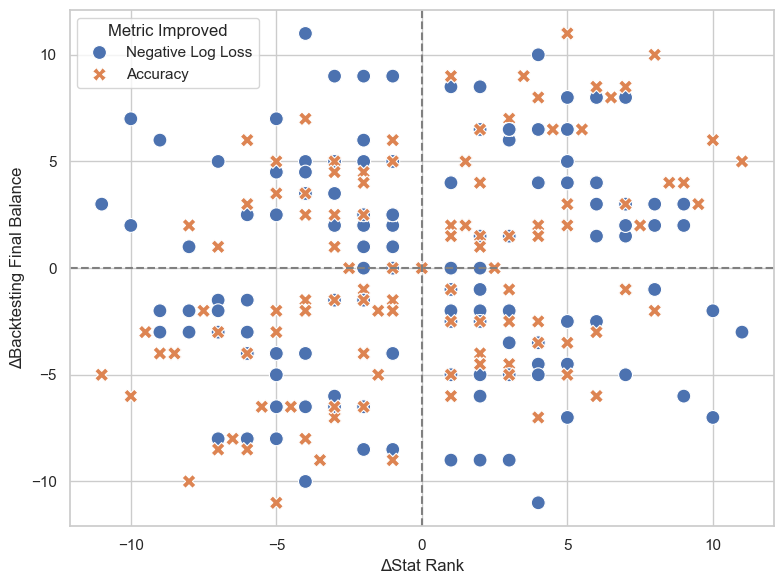

<Figure size 640x480 with 0 Axes>

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

def scatter_delta_plot_stat(df, delta_stat_col='ΔStat Rank', delta_util_col='ΔBacktesting Final Value'):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=delta_stat_col, y=delta_util_col, hue='Metric Improved', style='Metric Improved', s=100)

    # Add center lines
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    # plt.title(f"{delta_stat_col} vs ΔBacktesting Final Value")
    plt.xlabel(delta_stat_col)
    plt.ylabel('ΔBacktesting Final Balance')
    plt.tight_layout()
    plt.show()
    return plt

plot = scatter_delta_plot_stat(augmented, delta_stat_col='ΔStat Rank', delta_util_col='ΔBacktesting Final Value')
plot.savefig('scatter_utility_delta_plot.pdf', format='pdf', bbox_inches='tight', dpi=300)


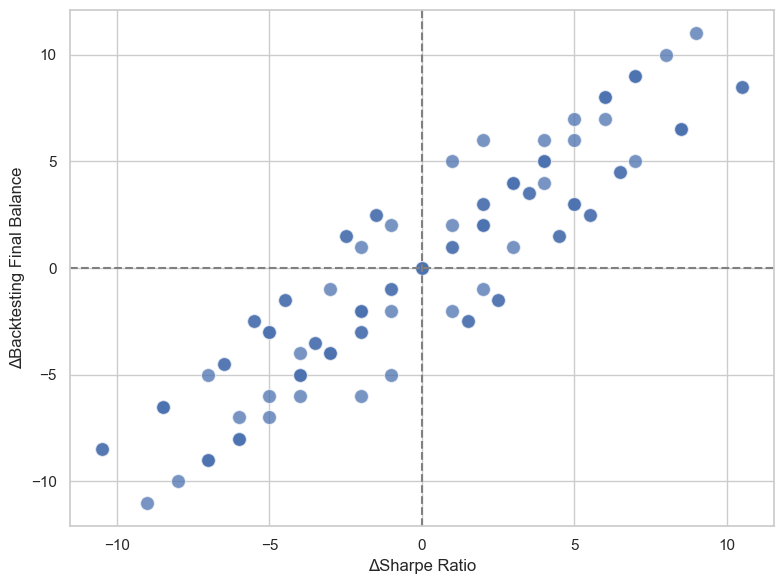

<Figure size 640x480 with 0 Axes>

In [177]:
def scatter_delta_plot(df, delta_stat_col='ΔSharpe Ratio', delta_util_col='ΔBacktesting Final Value'):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=delta_stat_col, y=delta_util_col, s=100, alpha=0.5)

    # Add center lines
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    # plt.title(f"{delta_stat_col} vs ΔBacktesting Final Balance")
    plt.tight_layout()
    plt.ylabel('ΔBacktesting Final Balance')
    plt.show()
    return plt
plot = scatter_delta_plot(augmented, delta_stat_col='ΔSharpe Ratio', delta_util_col='ΔBacktesting Final Value')
plot.savefig('scatter_utility_delta_plot_sharpe.pdf', format='pdf', bbox_inches='tight', dpi=300)

## RQ2: Do classification metrics align with financial performance?

We evaluate how well validation-time statistical metrics correlate with test-time utility metrics. Both Pearson (linear) and Spearman (monotonic) correlations are used to quantify these relationships.

In [178]:
def compute_val_vs_test_correlation(df, val_prefix="_val", test_metrics=None):
    import pandas as pd

    if test_metrics is None:
        test_metrics = ['Backtesting Final Value_test', 'Sharpe Ratio_test']

    # Select only the validation metric columns
    val_columns = [col for col in df.columns if col.endswith(val_prefix)]
    
    # Keep only the relevant columns (validation + test targets)
    columns_of_interest = val_columns + test_metrics
    df_corr = df[columns_of_interest].copy()

    # Compute correlations
    correlation_results = {}
    for target in test_metrics:
        corr_series = df_corr.corr(method='spearman')[target][val_columns]
        correlation_results[target] = corr_series

    return pd.DataFrame(correlation_results)


In [179]:
spearman_correlation_df = compute_val_vs_test_correlation(
    df=df_neg_log_loss,
    val_prefix="_val",
    test_metrics=['Backtesting Final Value_test', 'Sharpe Ratio_test']
)

print(spearman_correlation_df)


                              Backtesting Final Value_test  Sharpe Ratio_test
AUC_val                                           0.376489           0.373958
Accuracy_val                                      0.447550           0.431864
Adjusted Expected Return_val                      0.180642           0.151117
Backtesting Accuracy_val                          0.300854           0.293891
Backtesting Final Value_val                       0.755214           0.745188
Brier Score_val                                  -0.584284          -0.569084
EPEL_val                                          0.294377           0.281041
EV_val                                            0.294377           0.281041
Expected Growth Rate_val                          0.181657           0.152189
F1 Score_val                                     -0.180018          -0.177693
Negative Log Loss_val                             0.585257           0.570326
Average ROI per Trade_val                         0.583341      

In [180]:
def compute_ranked_correlation_by_asset(df, val_prefix="_val", test_metrics=None):
    import pandas as pd

    if test_metrics is None:
        test_metrics = ['Backtesting Final Value_test', 'Sharpe Ratio_test']

    # Identify all validation metric columns
    val_columns = [col for col in df.columns if col.endswith(val_prefix)]

    # All metrics of interest (val + test)
    metric_columns = val_columns + test_metrics

    # Step 1: Rank metrics within each asset
    ranked_df = df.copy()
    for col in metric_columns:
        ranked_df[f"{col}_rank"] = ranked_df.groupby("asset")[col].rank(ascending=False)

    # Step 2: Extract only the ranked columns
    ranked_columns = [f"{col}_rank" for col in metric_columns]
    ranked_data = ranked_df[ranked_columns]

    # Step 3: Compute correlations between val ranks and each test metric rank
    correlation_results = {}
    for test_metric in test_metrics:
        test_rank_col = f"{test_metric}_rank"
        val_rank_cols = [f"{col}_rank" for col in val_columns]
        corr_series = ranked_data[val_rank_cols + [test_rank_col]].corr(method='pearson')[test_rank_col][val_rank_cols]
        correlation_results[test_metric] = corr_series

    return pd.DataFrame(correlation_results)

correlation_df = compute_ranked_correlation_by_asset(
    df=df_neg_log_loss,
    val_prefix="_val",
    test_metrics=['Backtesting Final Value_test', 'Sharpe Ratio_test']
)
correlation_df_60 = compute_ranked_correlation_by_asset(
    df=df_neg_log_loss_60,
    val_prefix="_val",
    test_metrics=['Backtesting Final Value_test', 'Sharpe Ratio_test']
)
# correlation_df_90 = compute_ranked_correlation_by_asset(
#     df=df_neg_log_loss_90,
#     val_prefix="_val",
#     test_metrics=['Backtesting Final Value_test', 'Sharpe Ratio_test']
# )
print(correlation_df)


                                   Backtesting Final Value_test  \
AUC_val_rank                                           0.201532   
Accuracy_val_rank                                      0.135356   
Adjusted Expected Return_val_rank                     -0.076492   
Backtesting Accuracy_val_rank                          0.111316   
Backtesting Final Value_val_rank                       0.532168   
Brier Score_val_rank                                  -0.294887   
EPEL_val_rank                                         -0.103332   
EV_val_rank                                           -0.103332   
Expected Growth Rate_val_rank                         -0.076790   
F1 Score_val_rank                                      0.135094   
Negative Log Loss_val_rank                             0.296170   
Average ROI per Trade_val_rank                         0.390043   
Sharpe Ratio_val_rank                                  0.544136   
Sortino Ratio_val_rank                                 0.56705

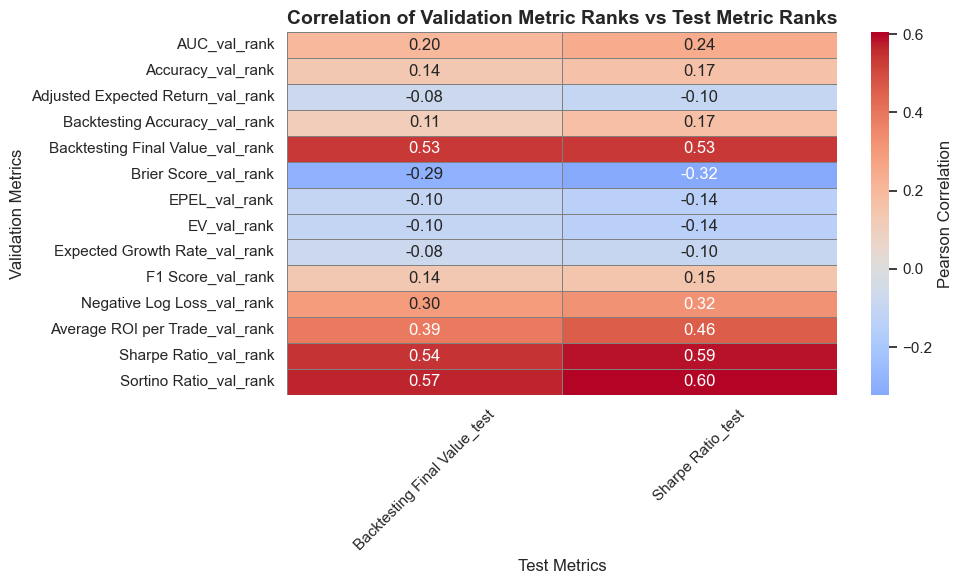

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(correlation_df, title="Correlation of Validation Metric Ranks vs Test Metric Ranks", correlation_type="Pearson"):
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")

    # Plot heatmap
    ax = sns.heatmap(
        correlation_df,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={'label': f'{correlation_type} Correlation'}
    )

    plt.title(title, fontsize=14, weight='bold')
    plt.ylabel("Validation Metrics")
    plt.xlabel("Test Metrics")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
correlation_df = compute_ranked_correlation_by_asset(
    df=df_neg_log_loss,
    val_prefix="_val",
    test_metrics=['Backtesting Final Value_test', 'Sharpe Ratio_test']
)

plot_correlation_heatmap(correlation_df)


In [182]:
df_neg_log_loss

model     asset              type   fake_type  AUC_test   AUC_val  \
0    ada_boost      AAPL            Stocks  All Assets  0.502120  0.504898   
1    ada_boost      AMZN            Stocks  All Assets  0.500109  0.505790   
2    ada_boost    AUDJPY             Forex  All Assets  0.526814  0.536982   
3    ada_boost    AUDUSD             Forex  All Assets  0.536562  0.547438   
4    ada_boost    CHFJPY             Forex  All Assets  0.460763  0.455758   
..         ...       ...               ...         ...       ...       ...   
295        sgd  X:ETHUSD  Cryptocurrencies  All Assets  0.508169  0.510480   
296        sgd  X:LTCUSD  Cryptocurrencies  All Assets  0.504422  0.509688   
297        sgd  X:XRPUSD  Cryptocurrencies  All Assets  0.491642  0.490689   
298        sgd    XAGUSD       Commodities  All Assets  0.555571  0.555872   
299        sgd    XAUUSD       Commodities  All Assets  0.532329  0.530937   

     Accuracy_test  Accuracy_val  Adjusted Expected Return_test  \
0         0.500286      0.505931                   3.992786e-05   
1         0.504612      0.507477                   1.274610e-02   
2         0.517686      0.519572                   3.776273e-06   
3         0.536059      0.550759                   1.148828e-02   
4         0.508100      0.520448                   7.398745e-03   
..             ...           ...                            ...   
295       0.505689      0.506991                   6.962145e-07   
296       0.502761      0.512272                   7.184105e-06   
297       0.503209      0.505171                   4.502340e-06   
298       0.542787      0.542072                   6.758095e-03   
299       0.521144      0.519952                   4.225117e-05   

     Adjusted Expected Return_val  ...  F1 Score_test  F1 Score_val  \
0                    1.208367e-04  ...       0.580322      0.560928   
1                    1.882331e-03  ...       0.662696      0.664044   
2                    1.465626e-06  ...       0.664597      0.666850   
3                    1.469337e-02  ...       0.299807      0.302128   
4                    5.780217e-03  ...       0.673760      0.684128   
..                            ...  ...            ...           ...   
295                  3.847199e-07  ...       0.544256      0.490871   
296                  0.000000e+00  ...       0.627402      0.660649   
297                  0.000000e+00  ...       0.669304      0.671241   
298                  6.771324e-03  ...       0.576614      0.572087   
299                  3.112139e-05  ...       0.563116      0.556813   

     Negative Log Loss_test  Negative Log Loss_val  \
0                 -0.693936              -0.693682   
1                 -0.697336              -0.693910   
2                 -0.691991              -0.691611   
3                 -0.689067              -0.685627   
4                 -0.699119              -0.696729   
..                      ...                    ...   
295               -0.693035              -0.692976   
296               -0.693180              -0.692766   
297               -0.693624              -0.693301   
298               -0.688700              -0.688700   
299               -0.691774              -0.691643   

     Average ROI per Trade_test  Average ROI per Trade_val  Sharpe Ratio_test  \
0                     -0.047222                  -0.325926          -0.401421   
1                     -0.114961                  -0.169708          -7.468372   
2                      0.110577                  -0.037500           1.448669   
3                      0.014015                   0.044209           2.620047   
4                     -0.166565                  -0.168008          -8.803844   
..                          ...                        ...                ...   
295                    0.750000                   0.750000           1.595303   
296                   -0.152344                   0.000000          -1.387558   
297                   -0.083333     

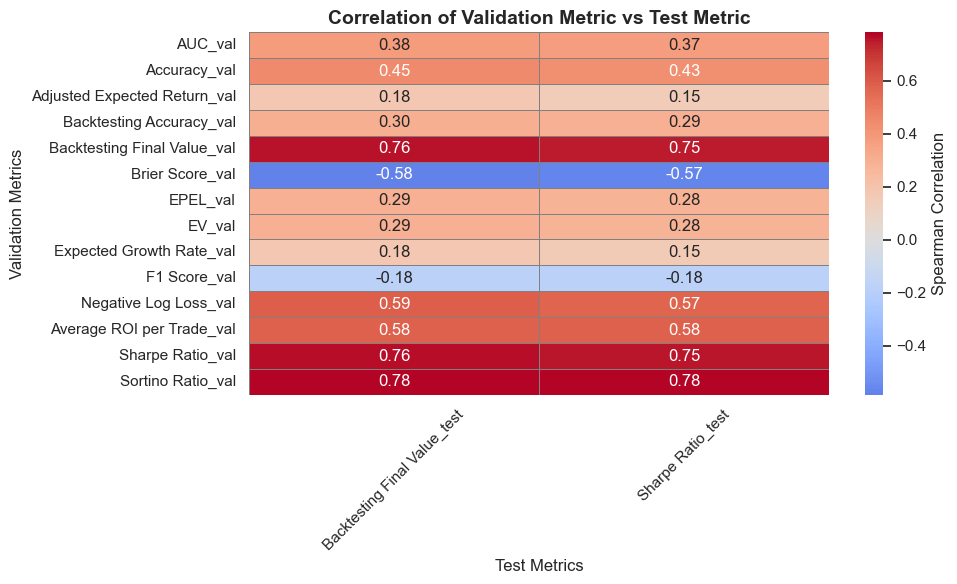

In [183]:
plot_correlation_heatmap(spearman_correlation_df, title="Correlation of Validation Metric vs Test Metric", correlation_type="Spearman")

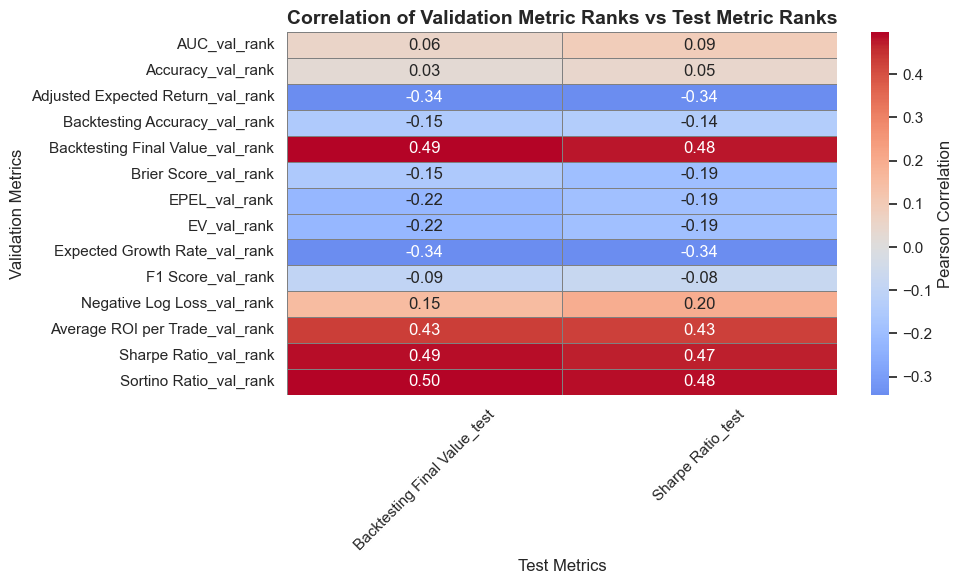

In [184]:
plot_correlation_heatmap(correlation_df_60, title="Correlation of Validation Metric Ranks vs Test Metric Ranks")


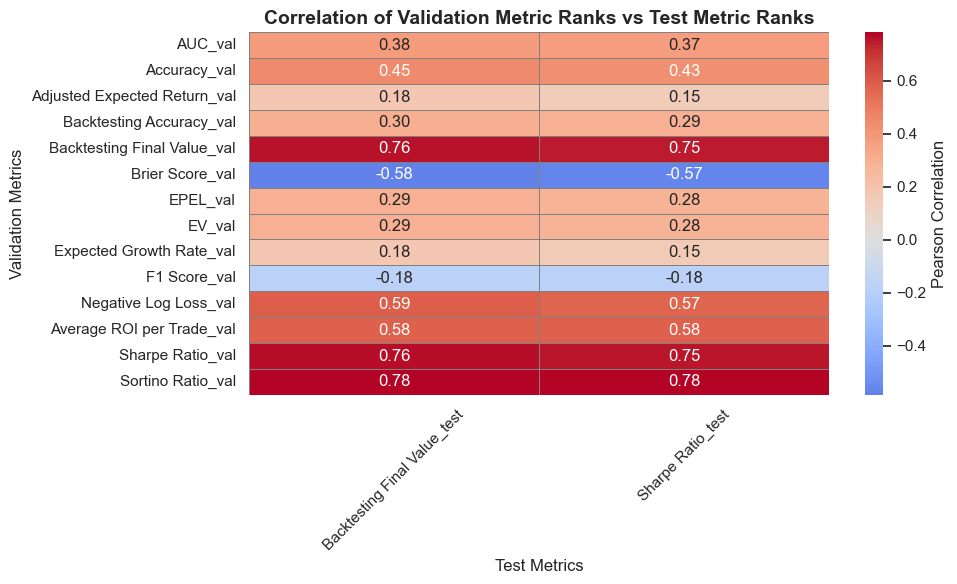

In [185]:
plot_correlation_heatmap(spearman_correlation_df)


In [186]:
spearman_correlation_df

Backtesting Final Value_test  Sharpe Ratio_test
AUC_val                                           0.376489           0.373958
Accuracy_val                                      0.447550           0.431864
Adjusted Expected Return_val                      0.180642           0.151117
Backtesting Accuracy_val                          0.300854           0.293891
Backtesting Final Value_val                       0.755214           0.745188
Brier Score_val                                  -0.584284          -0.569084
EPEL_val                                          0.294377           0.281041
EV_val                                            0.294377           0.281041
Expected Growth Rate_val                          0.181657           0.152189
F1 Score_val                                     -0.180018          -0.177693
Negative Log Loss_val                             0.585257           0.570326
Average ROI per Trade_val                         0.583341           0.581893
Sharpe Ratio_val                                  0.761680           0.754858
Sortino Ratio_val                                 0.781751           0.779662

In [187]:
correlation_df

Backtesting Final Value_test  \
AUC_val_rank                                           0.201532   
Accuracy_val_rank                                      0.135356   
Adjusted Expected Return_val_rank                     -0.076492   
Backtesting Accuracy_val_rank                          0.111316   
Backtesting Final Value_val_rank                       0.532168   
Brier Score_val_rank                                  -0.294887   
EPEL_val_rank                                         -0.103332   
EV_val_rank                                           -0.103332   
Expected Growth Rate_val_rank                         -0.076790   
F1 Score_val_rank                                      0.135094   
Negative Log Loss_val_rank                             0.296170   
Average ROI per Trade_val_rank                         0.390043   
Sharpe Ratio_val_rank                                  0.544136   
Sortino Ratio_val_rank                                 0.567056   

                                   Sharpe Ratio_test  
AUC_val_rank                                0.239017  
Accuracy_val_rank                           0.165165  
Adjusted Expected Return_val_rank          -0.099388  
Backtesting Accuracy_val_rank               0.170749  
Backtesting Final Value_val_rank            0.533284  
Brier Score_val_rank                       -0.321967  
EPEL_val_rank                              -0.142954  
EV_val_rank                                -0.142954  
Expected Growth Rate_val_rank              -0.097307  
F1 Score_val_rank                           0.147674  
Negative Log Loss_val_rank                  0.323250  
Average ROI per Trade_val_rank              0.460642  
Sharpe Ratio_val_rank                       0.588390  
Sortino Ratio_val_rank                      0.604329

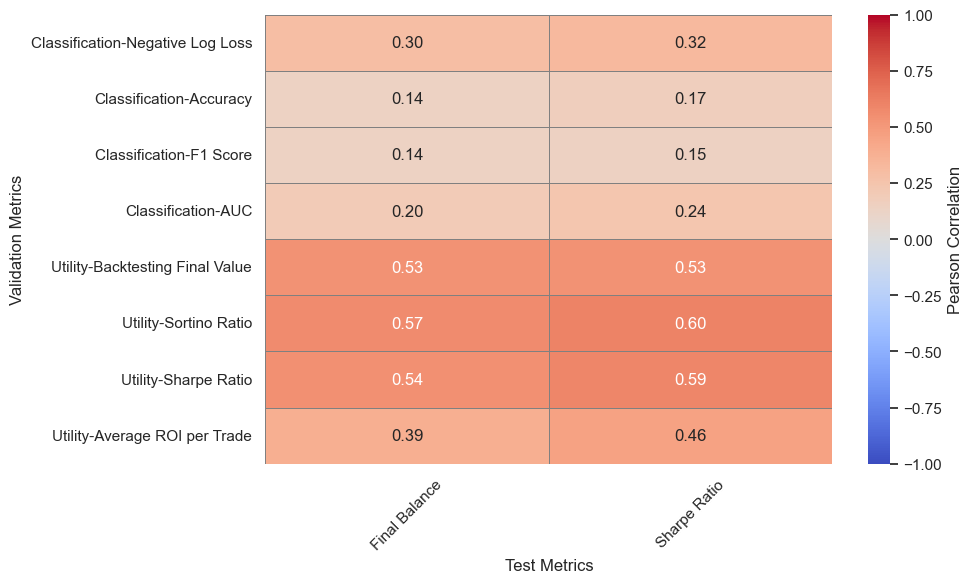

In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample: correlation_df = compute_val_vs_test_correlation(...)

plot_df = correlation_df.copy()
# 1. Define metric groups
statistical_metrics = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC']
utility_metrics = ['Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Average ROI per Trade']

# 2. Create label mapping (strip _val/_test)
clean_index = {f"{m}_val_rank": m for m in statistical_metrics + utility_metrics}
clean_columns = {
    'Backtesting Final Value_test': 'Final Balance',
    'Sharpe Ratio_test': 'Sharpe Ratio'
}

# 3. Rename both index and columns
plot_df.rename(index=clean_index, columns=clean_columns, inplace=True)

# 4. Reorder the DataFrame using cleaned labels
ordered_index = statistical_metrics + utility_metrics
ordered_columns = ['Final Balance', 'Sharpe Ratio']
plot_df = plot_df.loc[ordered_index, ordered_columns]

# 5. Optional: Grouping for visual clarity
group_labels = ['Classification'] * len(statistical_metrics) + ['Utility'] * len(utility_metrics)
plot_df.index = pd.MultiIndex.from_arrays([group_labels, plot_df.index])

# 6. Plot heatmap
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.heatmap(
    plot_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Pearson Correlation'}
)
# plt.title("Correlation of Validation Metric Ranks vs Test Metric Ranks", fontsize=14, weight='bold')
plt.xlabel("Test Metrics")
plt.ylabel("Validation Metrics")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('pearson_correlation_heatmap_classification_utility.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

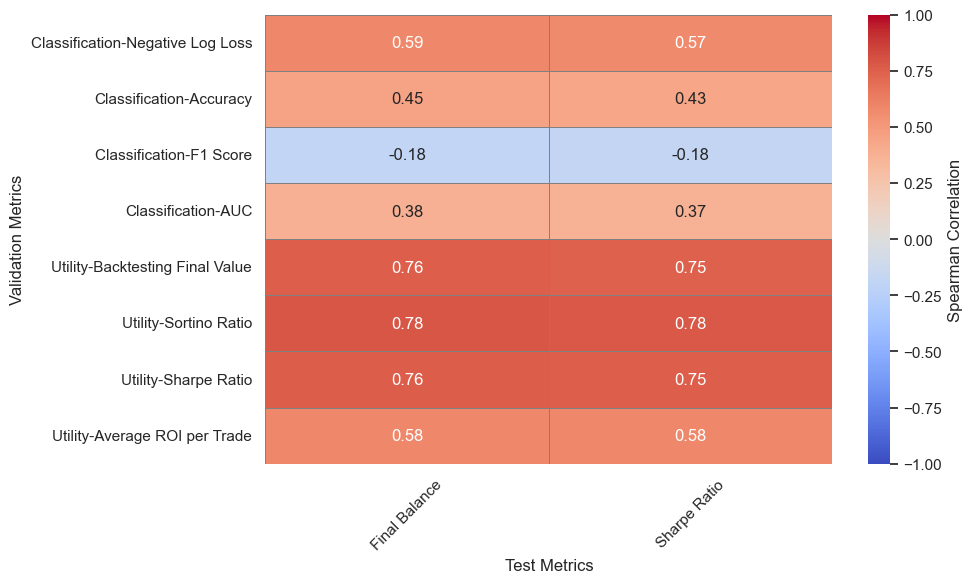

In [189]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample: correlation_df = compute_val_vs_test_correlation(...)

plot_df = spearman_correlation_df.copy()
# 1. Define metric groups
statistical_metrics = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC']
utility_metrics = ['Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Average ROI per Trade']

# 2. Create label mapping (strip _val/_test)
clean_index = {f"{m}_val": m for m in statistical_metrics + utility_metrics}
clean_columns = {
    'Backtesting Final Value_test': 'Final Balance',
    'Sharpe Ratio_test': 'Sharpe Ratio'
}

# 3. Rename both index and columns
plot_df.rename(index=clean_index, columns=clean_columns, inplace=True)

# 4. Reorder the DataFrame using cleaned labels
ordered_index = statistical_metrics + utility_metrics
ordered_columns = ['Final Balance', 'Sharpe Ratio']
plot_df = plot_df.loc[ordered_index, ordered_columns]

# 5. Optional: Grouping for visual clarity
group_labels = ['Classification'] * len(statistical_metrics) + ['Utility'] * len(utility_metrics)
plot_df.index = pd.MultiIndex.from_arrays([group_labels, plot_df.index])

# 6. Plot heatmap
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.heatmap(
    plot_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Spearman Correlation'}
)
# plt.title("Correlation of Validation Metric Ranks vs Test Metric Ranks", fontsize=14, weight='bold')
plt.xlabel("Test Metrics")
plt.ylabel("Validation Metrics")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('spearman_correlation_heatmap_classification_utility.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


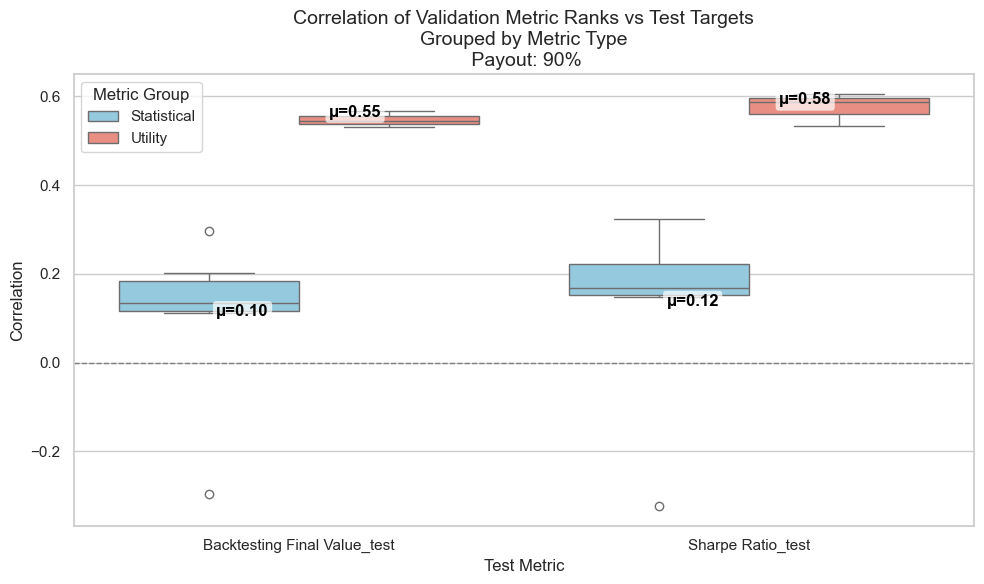

In [190]:
statistical_metrics = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC', 'Brier Score']
utility_metrics = ['Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Return over Risked Capital']
def classify_metric(metric_name, stat_list, util_list):
    for stat in stat_list:
        if stat in metric_name:
            return 'Statistical'
    for util in util_list:
        if util in metric_name:
            return 'Utility'
    return 'Other'

def prepare_grouped_correlation_df(df, val_prefix="_val", test_metrics=None):
    corr_df = compute_ranked_correlation_by_asset(
        df, val_prefix=val_prefix, test_metrics=test_metrics
    ).reset_index().rename(columns={"index": "Metric"})

    melted = corr_df.melt(id_vars="Metric", var_name="Test Metric", value_name="Correlation")
    melted["Metric Group"] = melted["Metric"].apply(
        lambda x: classify_metric(x, statistical_metrics, utility_metrics)
    )
    return melted


def plot_correlation_by_group(corr_melted_df, payout):
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    palette = {
    "Statistical": "skyblue",
    "Utility": "salmon",
    "Other": "lightgray"  # fallback color
    }
    corr_melted_df=corr_melted_df[corr_melted_df["Metric Group"] != "Other"]
    ax = sns.boxplot(
        x="Test Metric",
        y="Correlation",
        hue="Metric Group",
        data=corr_melted_df,
        palette=palette,
    )

    # Calculate and add mean value labels for each group
    for i, test_metric in enumerate(corr_melted_df["Test Metric"].unique()):
        metric_data = corr_melted_df[corr_melted_df["Test Metric"] == test_metric]
        
        for j, group in enumerate(metric_data["Metric Group"].unique()):
            group_data = metric_data[metric_data["Metric Group"] == group]
            mean_val = group_data["Correlation"].mean()
            
            # Find the position on the x-axis
            x_pos = i + (j - 0.5) * 0.25  # Adjust this value based on your box positions
            
            # Add text label with the mean value
            ax.text(x_pos, mean_val, f"μ={mean_val:.2f}", 
                   ha='center', va='bottom', fontweight='bold', color='black',
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

    plt.title(f"Correlation of Validation Metric Ranks vs Test Targets\nGrouped by Metric Type\n Payout: {payout}%", fontsize=14)
    plt.axhline(0, linestyle="--", color="gray", linewidth=1)
    plt.tight_layout()
    plt.legend(title="Metric Group")
    plt.show()
test_targets = ['Backtesting Final Value_test', 'Sharpe Ratio_test']

corr_melted_df = prepare_grouped_correlation_df(
    df=df_neg_log_loss,
    val_prefix="_val",
    test_metrics=test_targets
)

plot_correlation_by_group(corr_melted_df, payout=90)


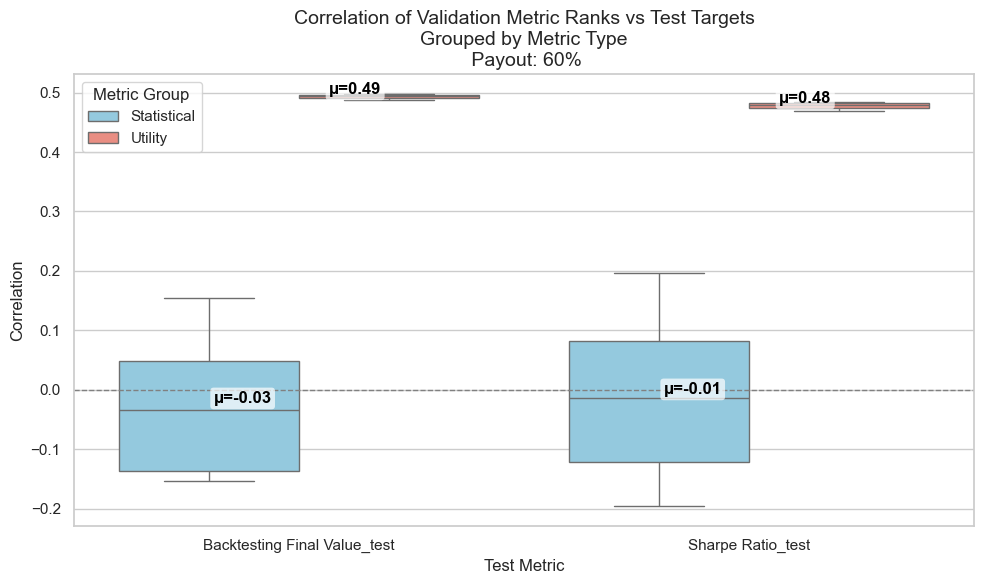

In [191]:
corr_melted_df_60 = prepare_grouped_correlation_df(
    df=df_neg_log_loss_60,
    val_prefix="_val",
    test_metrics=test_targets
)

plot_correlation_by_group(corr_melted_df_60, payout=60)

In [192]:
from scipy.stats.stats import pearsonr, spearmanr, kendalltau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression


def calculate_correlation(df, feature_columns, target_column, method):
    results = []
    
    for asset_type, group in df.groupby("fake_type"):
        group = group.dropna(subset=feature_columns + [target_column])
        
        if len(group) >= 3:
            correlations = {}
            p_values = {}
            
            for feature in feature_columns:
                x = group[feature]
                y = group[target_column]
                
                if method == 'pearson':
                    corr, p = pearsonr(x, y)
                elif method == 'spearman':
                    corr, p = spearmanr(x, y)
                elif method == 'kendall':
                    corr, p = kendalltau(x, y)
                elif method == 'mutual_info':
                    corr = mutual_info_regression(x.to_frame(), y, discrete_features=False)[0]
                    p = np.nan  # MI has no p-value
                else:
                    raise ValueError("Unknown method: " + method)
                
                correlations[feature] = corr
                p_values[feature] = p
            
            max_corr_feature = max(correlations.items(), key=lambda x: abs(x[1]))[0]
        else:
            correlations = {feature: np.nan for feature in feature_columns}
            p_values = {feature: np.nan for feature in feature_columns}
            max_corr_feature = None
        
        results.append({
            "asset_type": asset_type,
            **{f"corr_{feature}": correlations[feature] for feature in feature_columns},
            **{f"pval_{feature}": p_values[feature] for feature in feature_columns},
            "most_correlated": max_corr_feature
        })
    
    return pd.DataFrame(results)

def plot_correlation(df, feature_columns, title):
    x = np.arange(len(df))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = []
    
    for i, feature in enumerate(feature_columns):
        bars.append(ax.bar(x + i * width, df[f"corr_{feature}"], width, label=feature))
    
    ax.set_ylabel('Correlation')
    ax.set_title(title)
    ax.set_xticks(x + width * (len(feature_columns) / 2))
    ax.set_xticklabels(df["asset_type"], rotation=45, ha='right')
    ax.legend()
    
    # Add p-values if present
    if f"pval_{feature_columns[0]}" in df.columns:
        for i, asset_type in enumerate(df["asset_type"]):
            for j, feature in enumerate(feature_columns):
                ax.text(bars[j][i].get_x() + bars[j][i].get_width()/2, bars[j][i].get_height(),
                        f"p={df[f'pval_{feature}'][i]:.3f}", ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()



/var/folders/_v/kmc13qk97rs_tg7g815jf78m0000gn/T/ipykernel_20489/1093981018.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, spearmanr, kendalltau
/var/folders/_v/kmc13qk97rs_tg7g815jf78m0000gn/T/ipykernel_20489/1093981018.py:1: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, spearmanr, kendalltau
/var/folders/_v/kmc13qk97rs_tg7g815jf78m0000gn/T/ipykernel_20489/1093981018.py:1: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, spearmanr, kendalltau


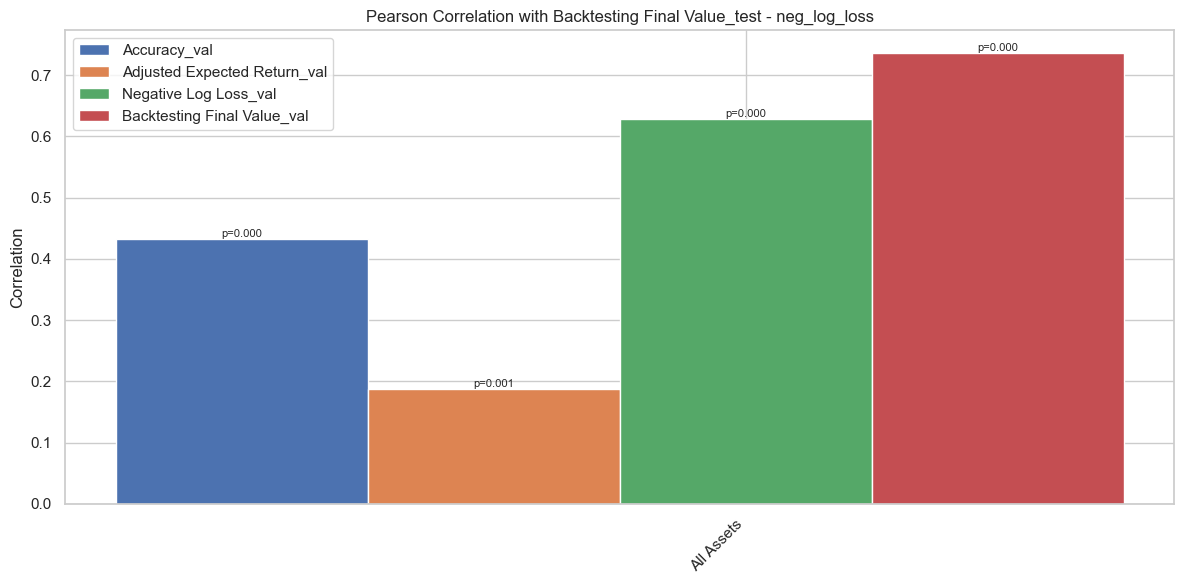

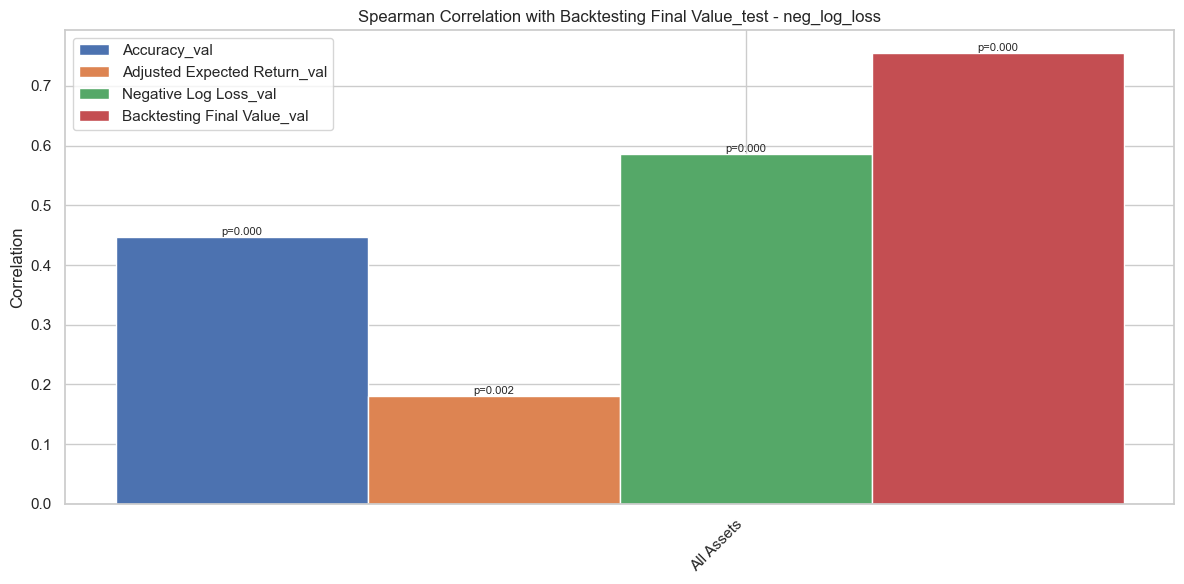

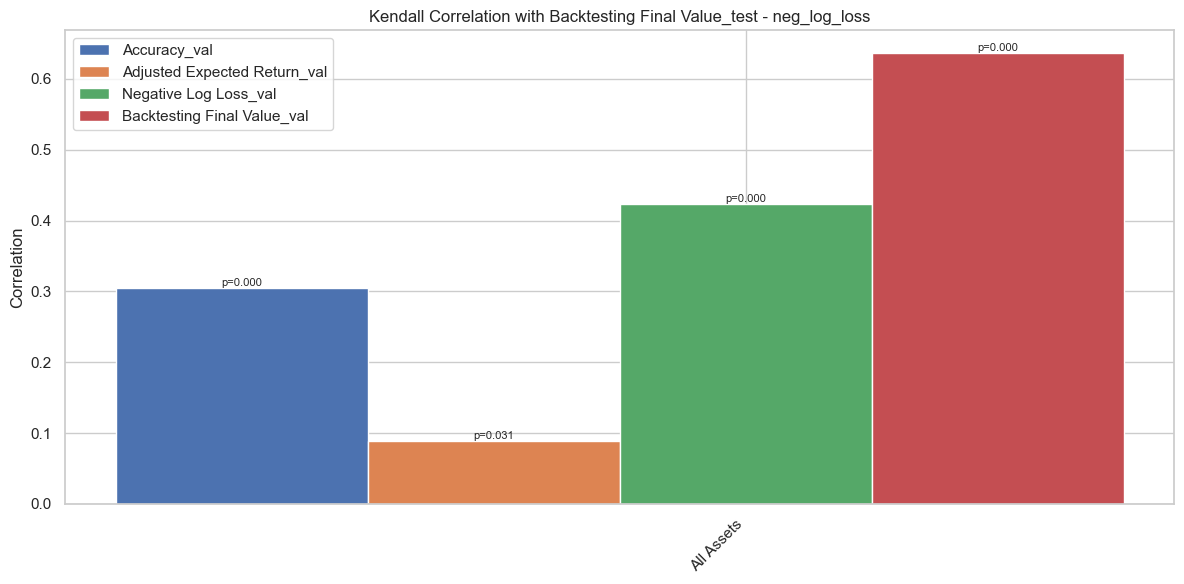

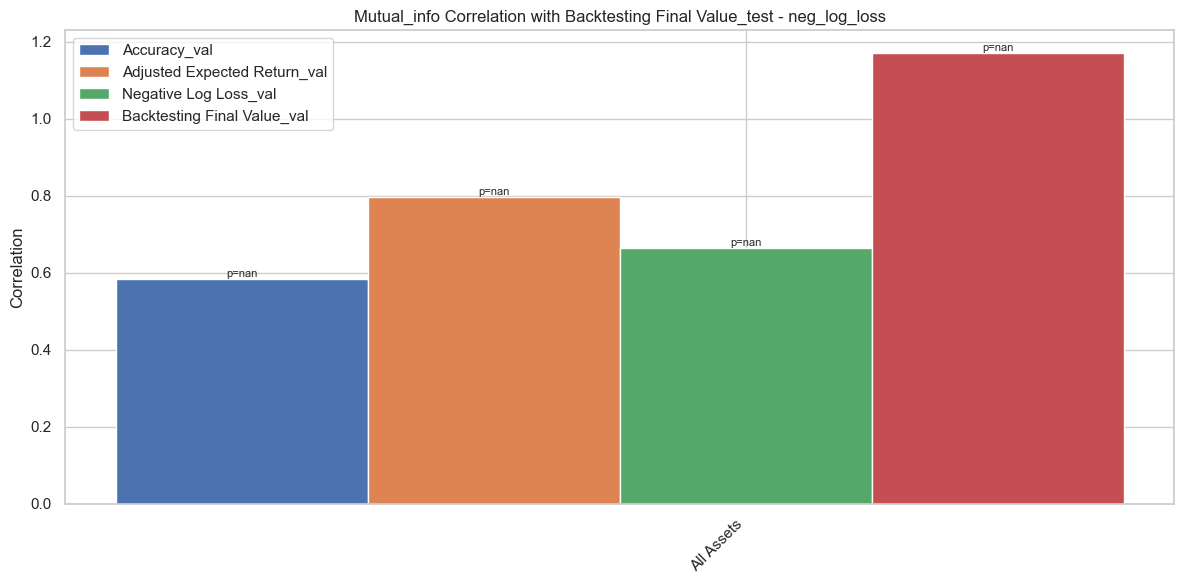

In [193]:
# Example usage:
feature_columns = ["Accuracy_val", "Adjusted Expected Return_val", "Negative Log Loss_val", "Backtesting Final Value_val"]
target_column = "Backtesting Final Value_test"

for name, df in [("neg_log_loss", df_neg_log_loss)]:
    for method in ["pearson", "spearman", "kendall", "mutual_info"]:
        result_df = calculate_correlation(df, feature_columns, target_column, method)
        plot_correlation(result_df, feature_columns, f"{method.capitalize()} Correlation with {target_column} - {name}")

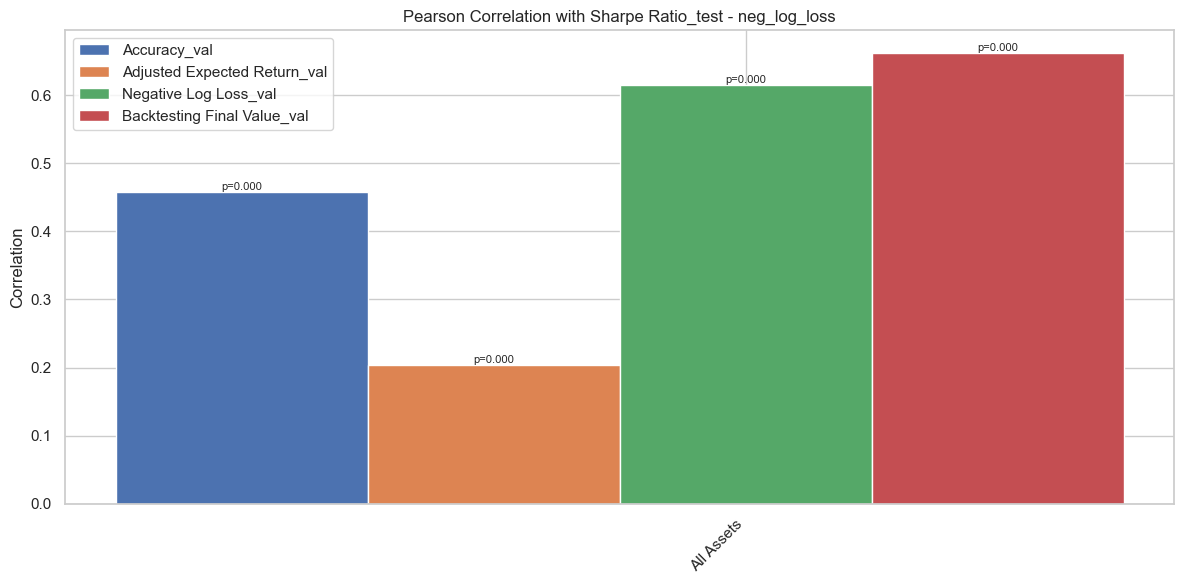

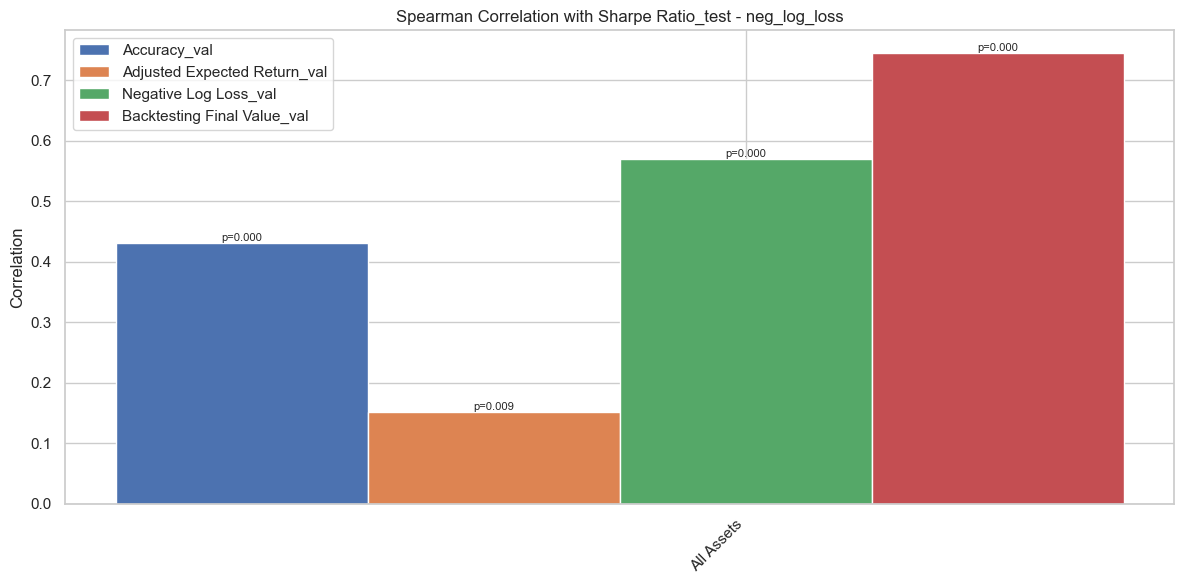

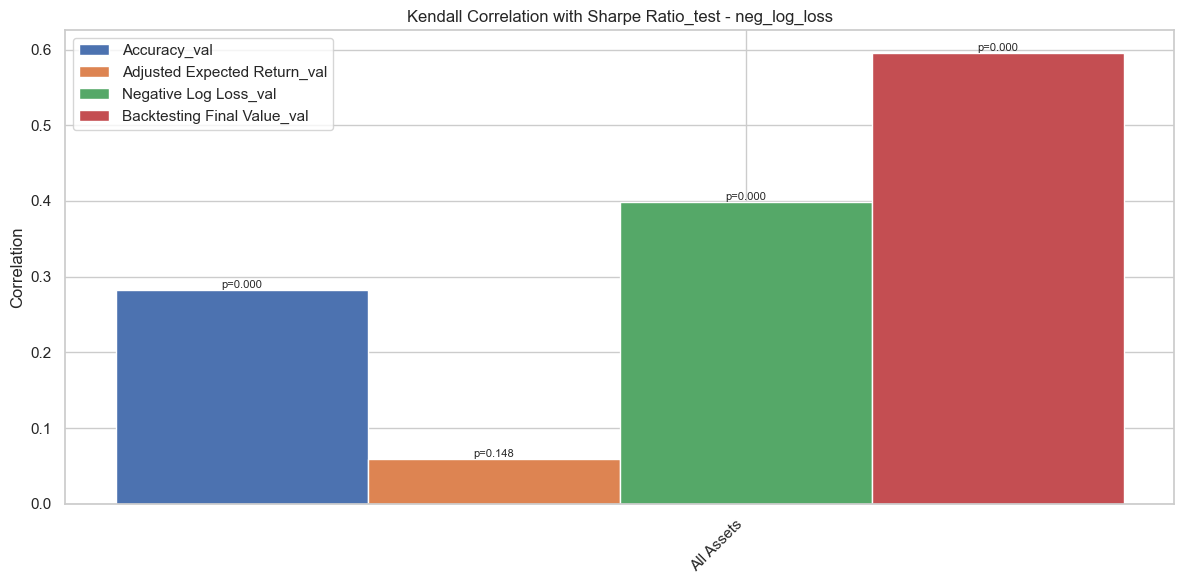

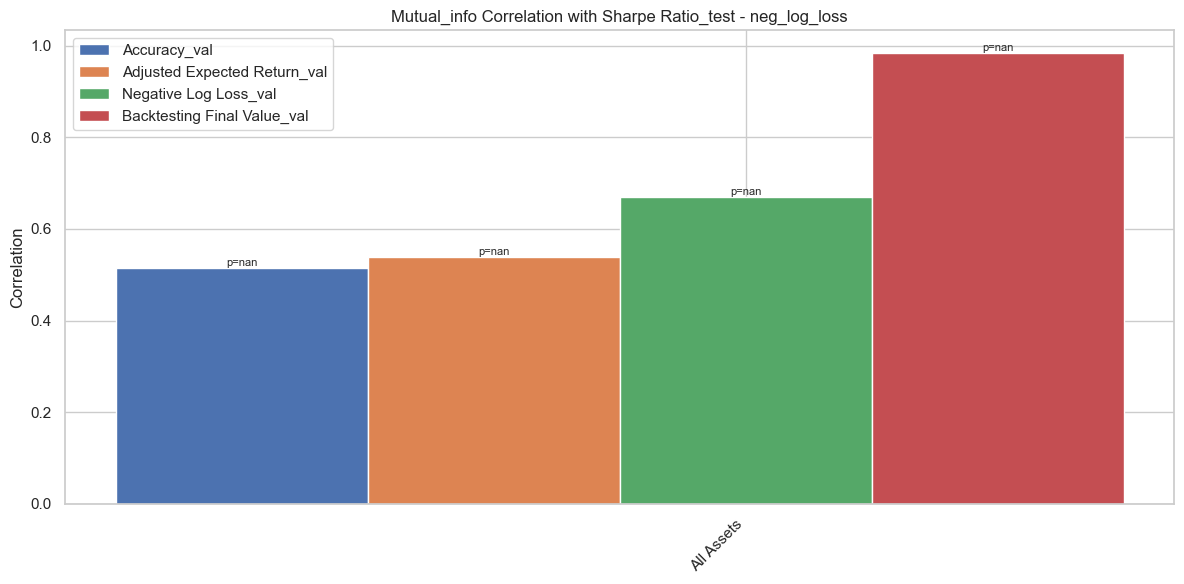

In [194]:
# Example usage:
feature_columns = ["Accuracy_val", "Adjusted Expected Return_val", "Negative Log Loss_val", "Backtesting Final Value_val"]
target_column = "Sharpe Ratio_test"

for name, df in [("neg_log_loss", df_neg_log_loss)]:
    for method in ["pearson", "spearman", "kendall", "mutual_info"]:
        result_df = calculate_correlation(df, feature_columns, target_column, method)
        plot_correlation(result_df, feature_columns, f"{method.capitalize()} Correlation with {target_column} - {name}")

In [195]:
metrics_val = ["Accuracy", "Adjusted Expected Return", "Negative Log Loss", "F1 Score", "Backtesting Final Value"]
metrics_test = ["Backtesting Final Value", "Backtesting Accuracy", "Sharpe Ratio", "Sortino Ratio",]
metrics_val = [ text + "_val" for text in metrics_val]
metrics_test = [ text + "_val" for text in metrics_test]
metrics = metrics_val + metrics_test

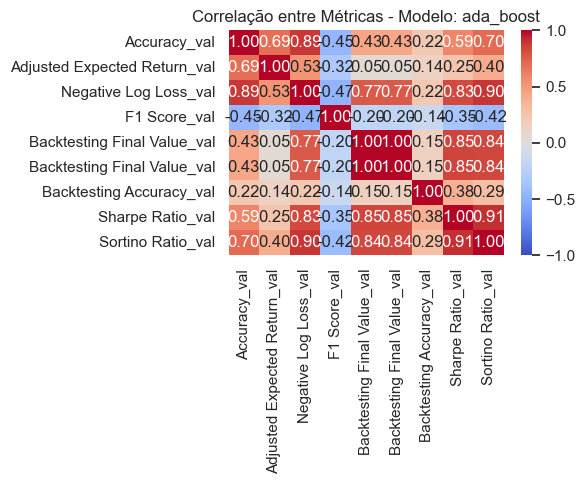

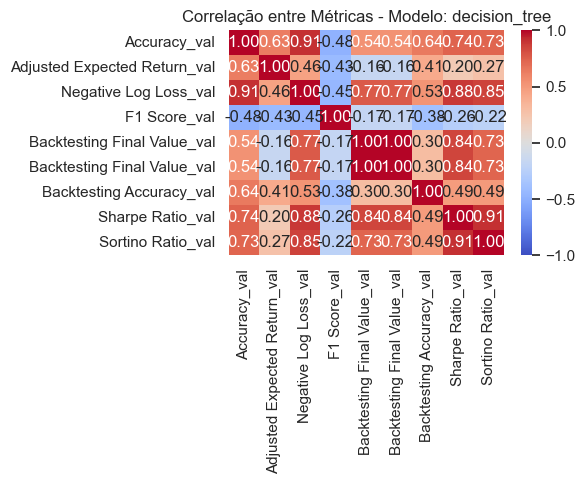

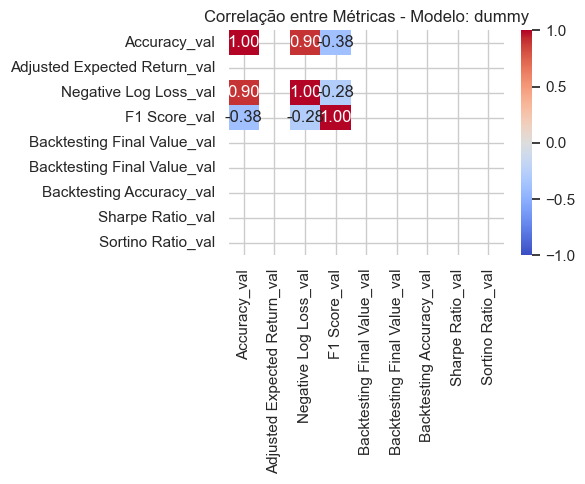

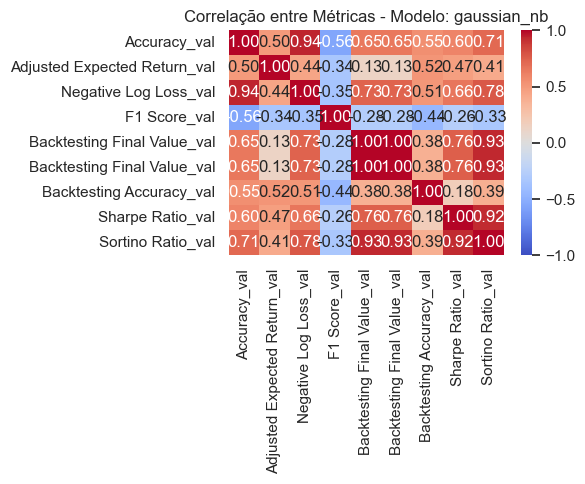

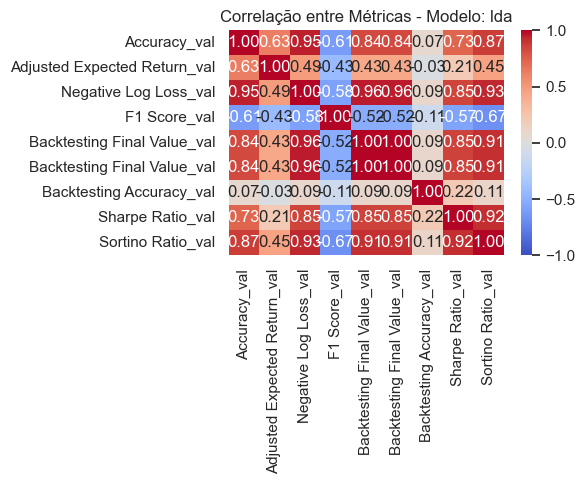

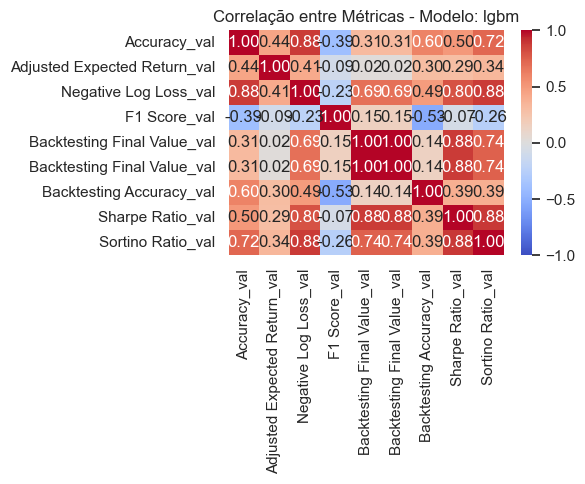

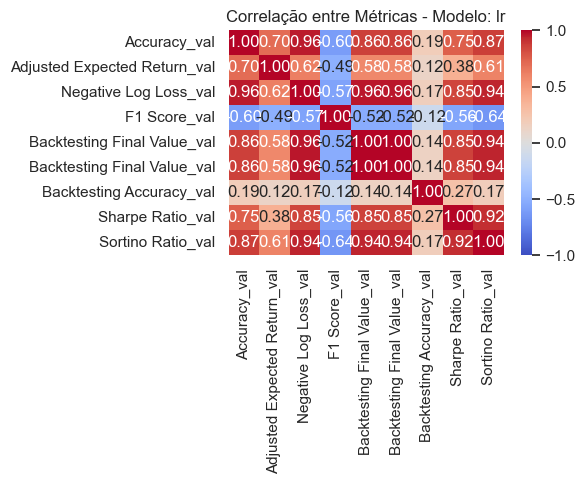

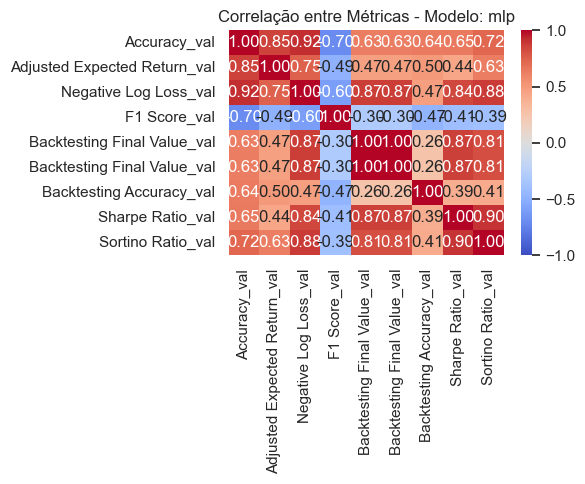

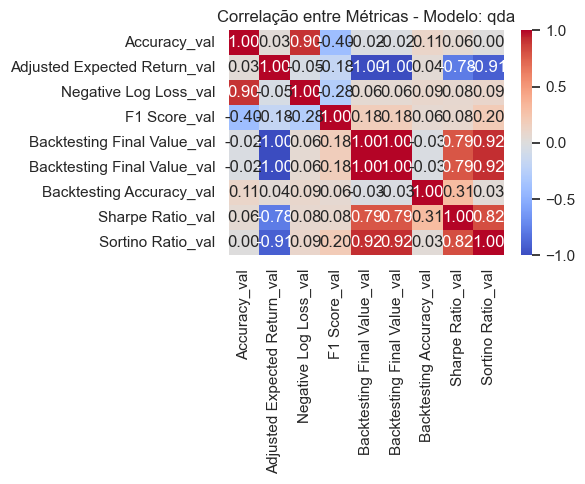

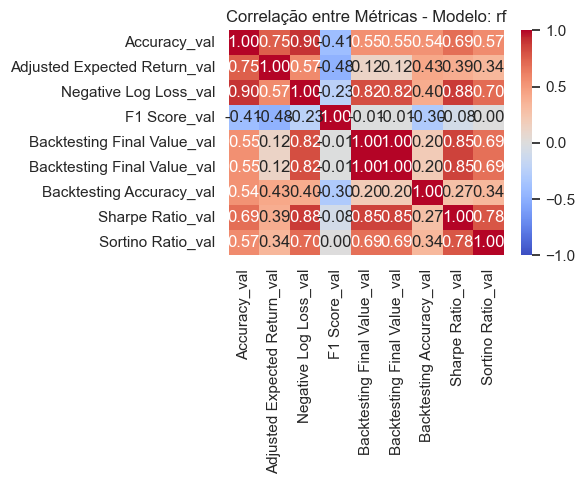

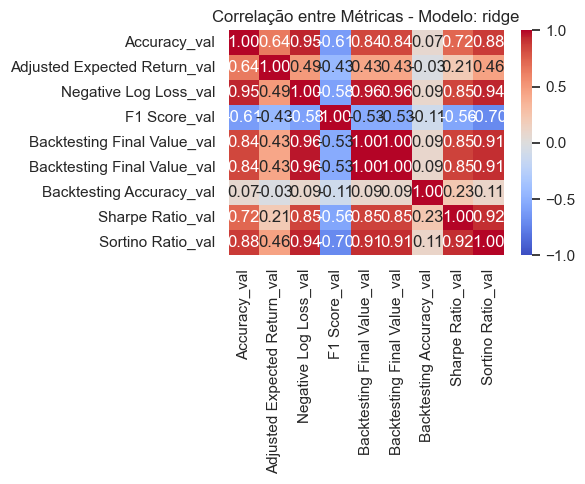

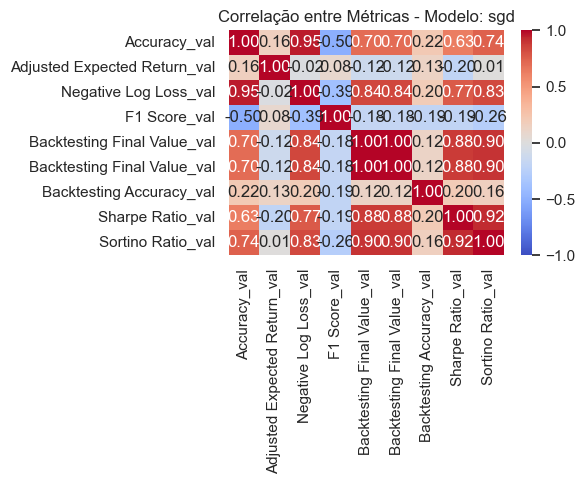

In [196]:

def plot_correlation_heatmaps(df):
    for model_name, group in df.groupby("model"):
        corr = group[metrics].corr()

        plt.figure(figsize=(6, 5))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
        plt.title(f'Correlação entre Métricas - Modelo: {model_name}')
        plt.tight_layout()
        plt.show()

plot_correlation_heatmaps(df_neg_log_loss)

In [197]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

results = []

for asset_type, group in df.groupby("type"):
    group = group.dropna(subset=["Accuracy_val", "Adjusted Expected Return_val", "Negative Log Loss_val", "Backtesting Final Value_test"])

    if len(group) >= 2:
        corr_acc, p_acc = pearsonr(group["Accuracy_val"], group["Backtesting Final Value_test"])
        corr_adj, p_adj = pearsonr(group["Adjusted Expected Return_val"], group["Backtesting Final Value_test"])
        corr_f1, p_f1 = pearsonr(group["Negative Log Loss_val"], group["Backtesting Final Value_test"])
    else:
        corr_acc, p_acc, corr_adj, p_adj, corr_f1, p_f1 = [np.nan] * 6

    # Which one is most correlated
    max_corr = max([(abs(corr_acc), "Accuracy"),
                    (abs(corr_adj), "Adjusted Expected Return"),
                    (abs(corr_f1), "Negative Log Loss")], key=lambda x: x[0])[1]

    results.append({
        "asset_type": asset_type,
        "corr_accuracy": corr_acc,
        "pval_accuracy": p_acc,
        "corr_adj_expected_return": corr_adj,
        "pval_adj": p_adj,
        "corr_f1": corr_f1,
        "pval_f1": p_f1,
        "most_correlated": max_corr
    })

correlation_df = pd.DataFrame(results)


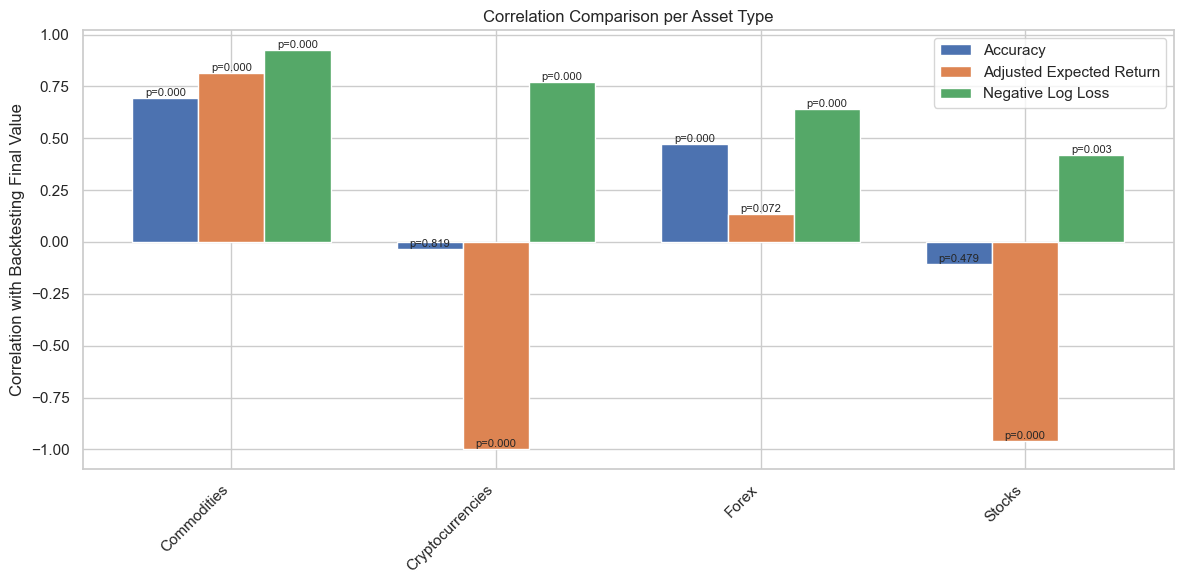

In [198]:
x = np.arange(len(correlation_df))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

bar1 = ax.bar(x - width, correlation_df["corr_accuracy"], width, label='Accuracy')
bar2 = ax.bar(x, correlation_df["corr_adj_expected_return"], width, label='Adjusted Expected Return')
bar3 = ax.bar(x + width, correlation_df["corr_f1"], width, label='Negative Log Loss')

# Add labels and formatting
ax.set_ylabel('Correlation with Backtesting Final Value')
ax.set_title('Correlation Comparison per Asset Type')
ax.set_xticks(x)
ax.set_xticklabels(correlation_df["asset_type"], rotation=45, ha='right')
ax.legend()

# Annotate bars with p-values
for i, (b1, b2, b3) in enumerate(zip(bar1, bar2, bar3)):
    ax.text(b1.get_x() + b1.get_width()/2, b1.get_height(), f"p={correlation_df['pval_accuracy'][i]:.3f}", 
            ha='center', va='bottom', fontsize=8, rotation=0)
    ax.text(b2.get_x() + b2.get_width()/2, b2.get_height(), f"p={correlation_df['pval_adj'][i]:.3f}", 
            ha='center', va='bottom', fontsize=8, rotation=0)
    ax.text(b3.get_x() + b3.get_width()/2, b3.get_height(), f"p={correlation_df['pval_f1'][i]:.3f}", 
            ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()


## RQ3: Are model rankings robust across metric types?

This section compares average model ranks across statistical and utility-based evaluation criteria. We investigate whether models that perform well in classification metrics also lead in financial outcomes.

In [199]:
def get_ranking(df):
    # Metrics of interest
    metrics = ["Accuracy", "Adjusted Expected Return", "Negative Log Loss", "F1 Score",  "Backtesting Final Value", "Backtesting Accuracy", "Sharpe Ratio", "Sortino Ratio",]
    # Group by model and compute mean
    grouped = df.groupby("model")[metrics].mean(numeric_only=True)

    # Rank each metric (lower is better for Negative Log Loss, higher is better for others)
    ranking = pd.DataFrame(index=grouped.index)
    ranking['Negative Log Loss Rank'] = grouped['Negative Log Loss'].rank(ascending=True, method='min')
    ranking['Accuracy Rank'] = grouped['Accuracy'].rank(ascending=False, method='min')
    ranking['Adjusted Expected Return Rank'] = grouped['Adjusted Expected Return'].rank(ascending=False, method='min')
    ranking['Backtesting Final Value Rank'] = grouped['Backtesting Final Value'].rank(ascending=False, method='min')
    ranking['F1 Score Rank'] = grouped['F1 Score'].rank(ascending=False, method='min')
    ranking['Backtesting Accuracy Rank'] = grouped['Backtesting Accuracy'].rank(ascending=False, method='min')
    ranking['Sharpe Ratio Rank'] = grouped['Sharpe Ratio'].rank(ascending=False, method='min')
    ranking['Sortino Ratio Rank'] = grouped['Sortino Ratio'].rank(ascending=False, method='min')

    # Optional: Calculate an overall average rank
    ranking['Average Rank'] = ranking.mean(axis=1)

    # Reset index to make 'model' a column
    ranking.reset_index(inplace=True)
    return ranking
# Show result


In [200]:
def rank_then_mean(ranked_df):
    metrics = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC',
               'Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Average ROI per Trade', 'EPEL', 'EV', 'Brier Score']
    
    # First rank for each asset, then get mean rank
    metrics = [col for col in ranked_df.columns if any(metric + '_test' in col for metric in metrics)]
    def process_asset_group(group):
        # Rank within the asset group (ascending=False means higher values get lower ranks)
        ranks = group[metrics].rank(ascending=False)
        return ranks
    
    # Group by asset, rank within each asset, then get mean rank
    result = ranked_df.groupby('model').apply(process_asset_group)
    mean_ranks = result.groupby(level=0)[metrics].mean()
    
    return mean_ranks

def mean_then_rank(ranked_df):
    metrics = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC',
               'Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Average ROI per Trade']
    metrics = [col for col in ranked_df.columns if any(metric + '_test' in col for metric in metrics)]
    # First get mean for each model across assets
    means = ranked_df.groupby('model')[metrics].mean()
    
    # Then rank the means
    final_ranks = means.rank(ascending=False)
    
    return final_ranks


In [201]:

# Define the metrics
statistical_metrics = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC', 'Brier Score']
utility_metrics = ['Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Average ROI per Trade']
rank_mean_stat = pd.DataFrame()
rank_mean_util = pd.DataFrame()
for metric in statistical_metrics:
    rank_mean_stat[metric] = ranked_df.groupby('model')[f"{metric}_test_rank"].mean()

for metric in utility_metrics:
    rank_mean_util[metric] = ranked_df.groupby('model')[f"{metric}_test_rank"].mean()

# rank_mean.sort_values(by='Negative Log Loss_test_rank', ascending=True, inplace=True)
# rank_mean.to_csv('rank_mean.csv', index=False)


In [202]:
rank_mean_stat

Negative Log Loss  Accuracy  F1 Score    AUC  Brier Score
model                                                                   
ada_boost                   6.84      6.48      5.60   4.92         6.24
decision_tree               5.52      6.66      7.60   6.36         7.32
dummy                       8.64      9.48      6.50  10.64         3.92
gaussian_nb                 7.44      8.44      6.76   8.08         5.32
lda                         5.48      4.72      6.22   4.88         7.96
lgbm                        7.16      8.22      7.50   7.00         5.68
lr                          4.88      3.86      6.20   4.08         8.84
mlp                         5.72      5.32      4.48   5.72         7.16
qda                         8.84      9.06      6.14   9.08         3.80
rf                          6.08      6.66      7.82   6.56         6.64
ridge                       5.56      4.34      6.10   4.76         7.92
sgd                         5.84      4.76      7.08   5.92         7.20

In [203]:
rank_mean_util

Backtesting Final Value  Sortino Ratio  Sharpe Ratio  \
model                                                                 
ada_boost                         7.14           6.98          7.10   
decision_tree                     5.88           5.56          6.08   
dummy                             6.46           6.24          6.42   
gaussian_nb                       6.48           6.58          6.52   
lda                               6.68           6.84          6.50   
lgbm                              5.34           4.94          5.18   
lr                                6.54           6.76          6.66   
mlp                               6.06           6.24          6.30   
qda                               7.54           7.58          7.66   
rf                                6.08           6.26          5.72   
ridge                             6.98           7.12          6.86   
sgd                               6.82           6.90          7.00   

               Average ROI per Trade  
model                                 
ada_boost                       6.94  
decision_tree                   6.68  
dummy                           6.46  
gaussian_nb                     6.28  
lda                             6.36  
lgbm                            4.98  
lr                              6.50  
mlp                             6.70  
qda                             8.22  
rf                              5.88  
ridge                           6.66  
sgd                             6.34

/var/folders/_v/kmc13qk97rs_tg7g815jf78m0000gn/T/ipykernel_20489/1935288735.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=melted_df, x='model', y='Rank', palette='Set3')


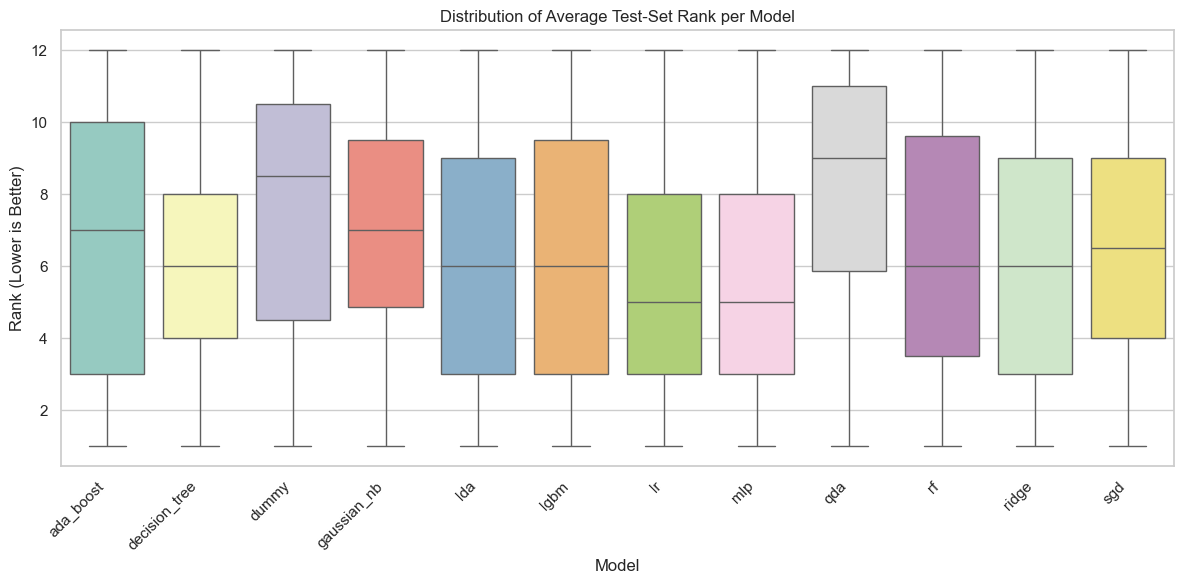

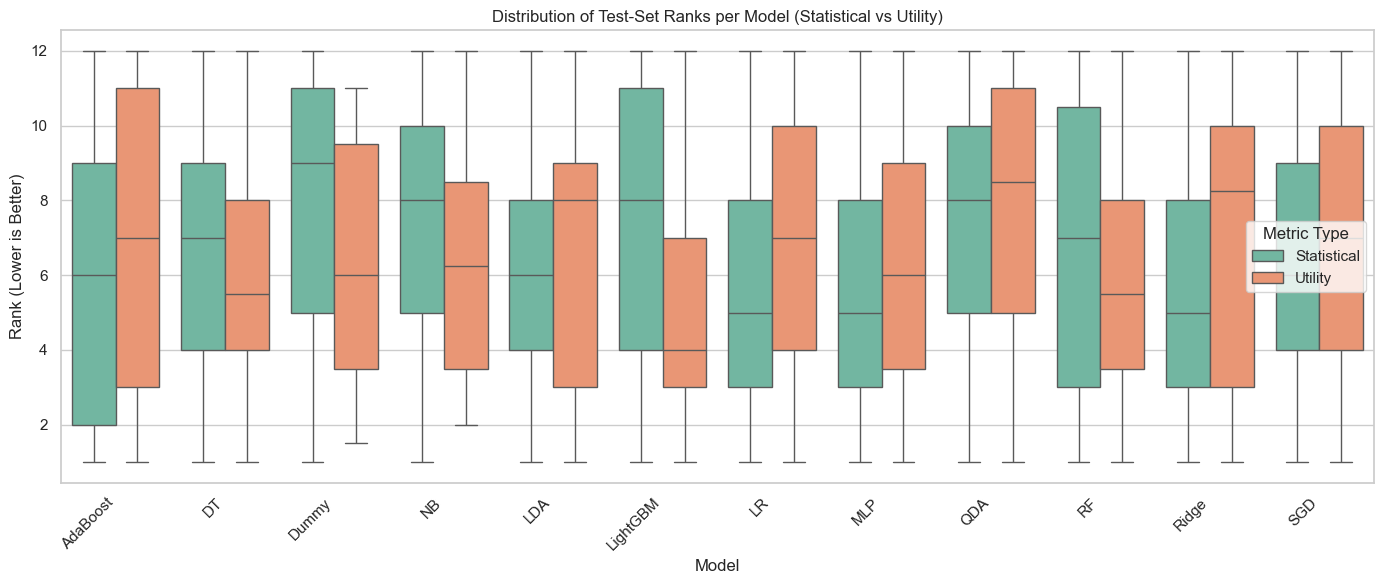

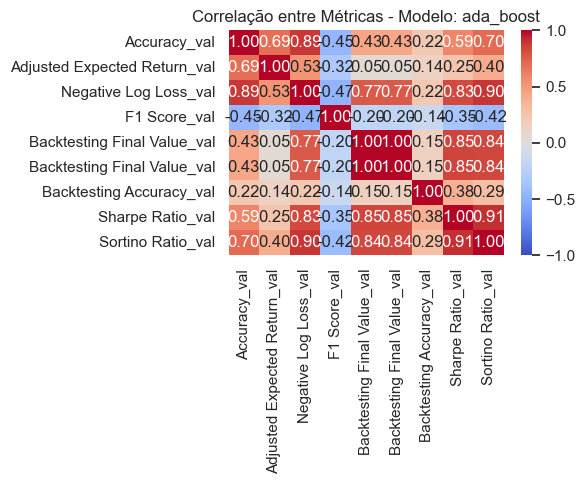

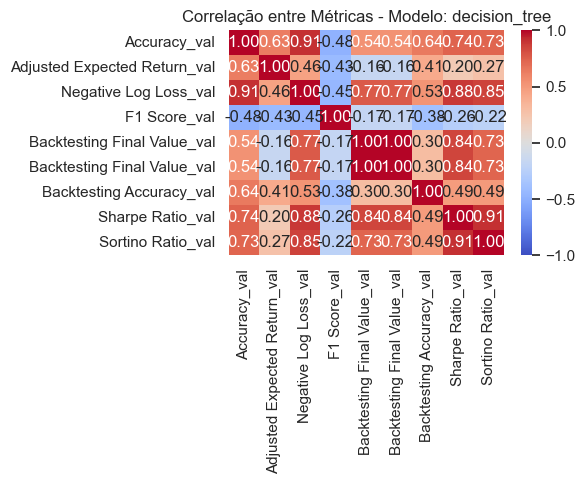

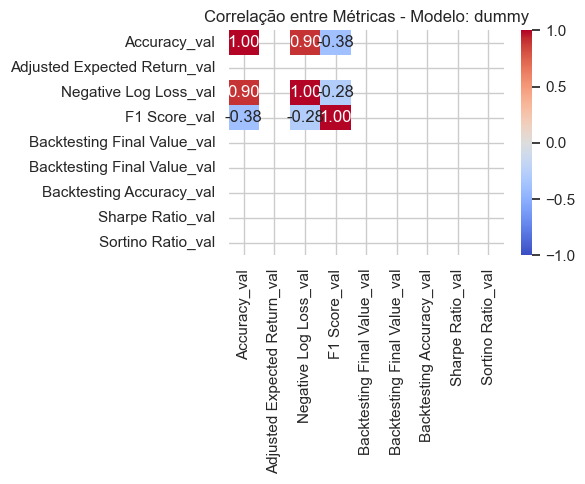

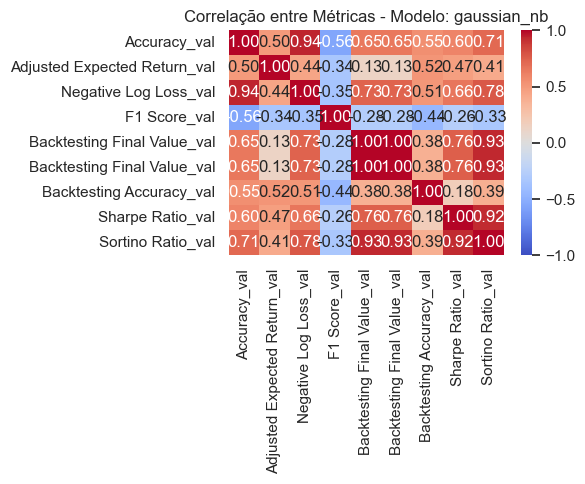

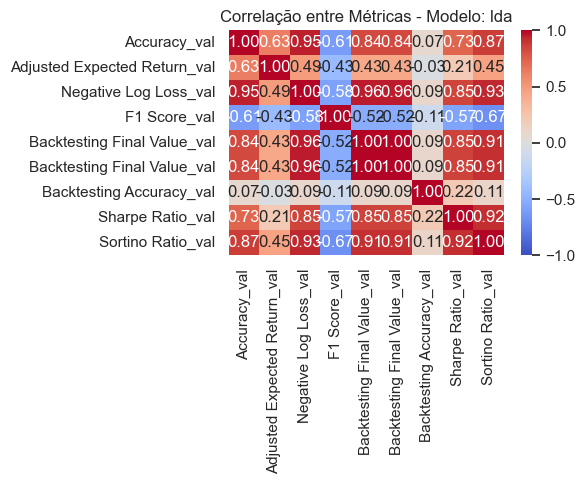

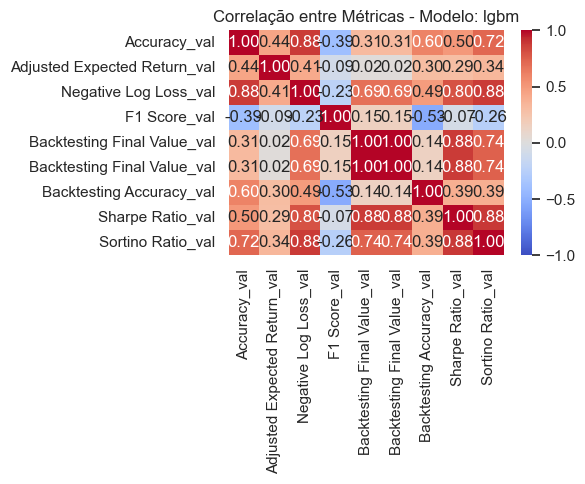

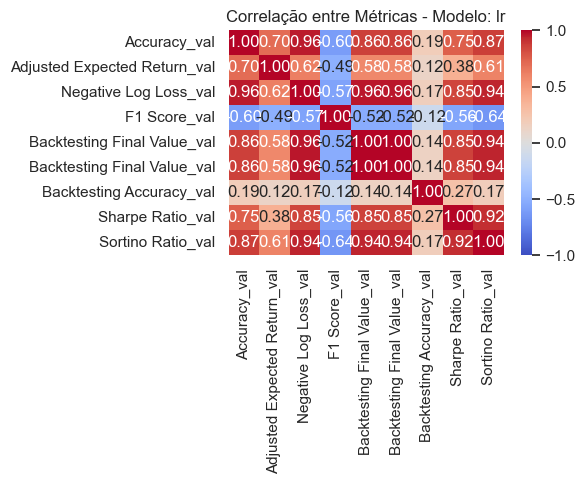

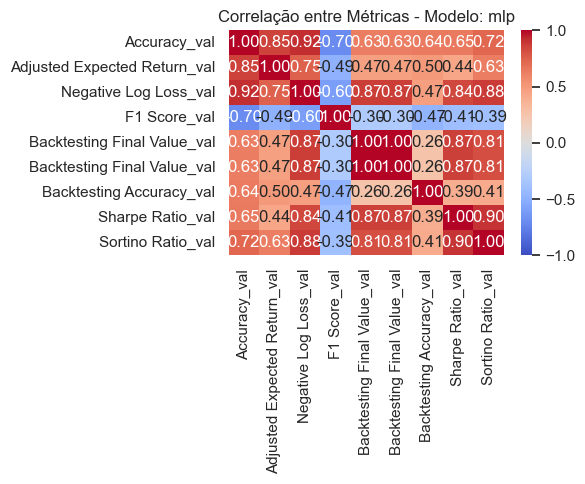

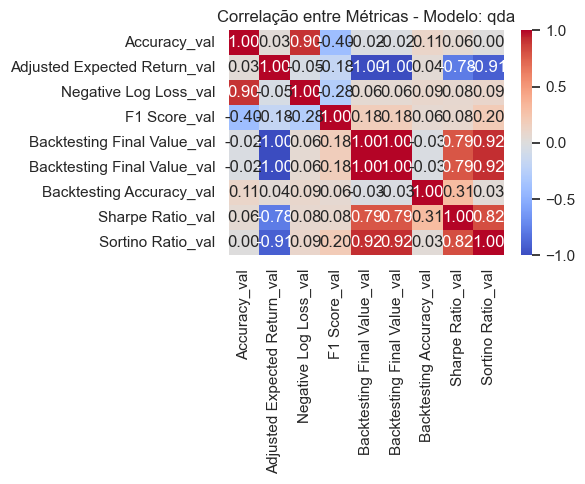

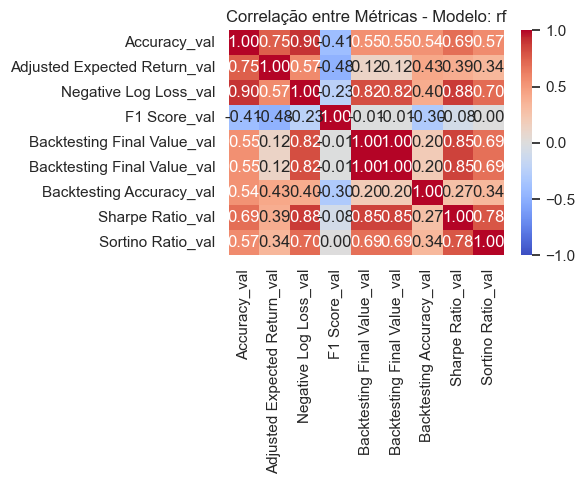

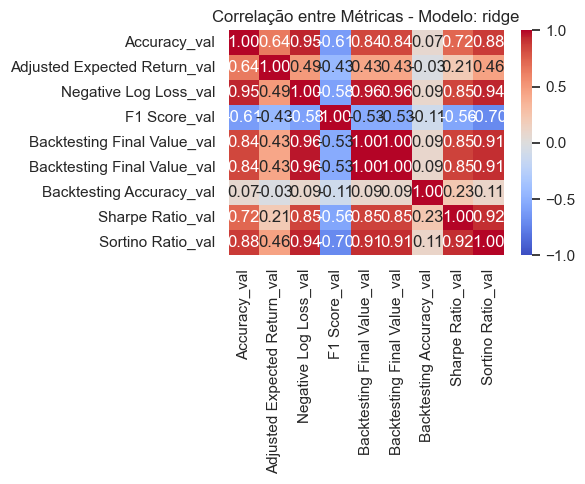

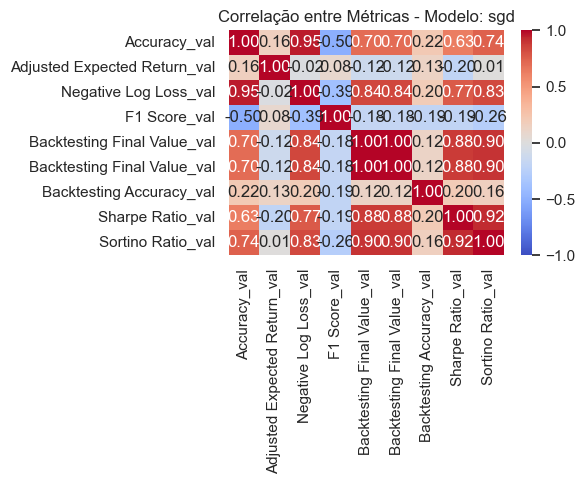

In [204]:

import seaborn as sns
# Define the relevant test metric names
statistical_metrics = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC']
utility_metrics = ['Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Average ROI per Trade']

# Generate the column names that hold test ranks
all_rank_cols = [f"{metric}_test_rank" for metric in statistical_metrics + utility_metrics]

# Reshape the data to long format for seaborn
melted_df = ranked_df[['model'] + all_rank_cols].melt(id_vars='model', var_name='Metric', value_name='Rank')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_df, x='model', y='Rank', palette='Set3')
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Average Test-Set Rank per Model")
plt.ylabel("Rank (Lower is Better)")
plt.xlabel("Model")
plt.tight_layout()

# Save and/or show the plot
# plt.savefig("average_test_rank_boxplot.png", dpi=300)
plt.show()
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define metric categories
statistical_metrics = ['Negative Log Loss', 'Accuracy', 'F1 Score', 'AUC', 'Brier Score']
utility_metrics = ['Backtesting Final Value', 'Sortino Ratio', 'Sharpe Ratio', 'Average ROI per Trade']

# Rank columns
statistical_rank_cols = [f"{metric}_test_rank" for metric in statistical_metrics]
utility_rank_cols = [f"{metric}_test_rank" for metric in utility_metrics]

# Melt and label each part
stat_melted = ranked_df[['model'] + statistical_rank_cols].melt(
    id_vars='model', var_name='Metric', value_name='Rank'
)
stat_melted['Metric Type'] = 'Statistical'

util_melted = ranked_df[['model'] + utility_rank_cols].melt(
    id_vars='model', var_name='Metric', value_name='Rank'
)
util_melted['Metric Type'] = 'Utility'

# Combine the data
combined_melted = pd.concat([stat_melted, util_melted], ignore_index=True)
# model_name_map = {
#     'ada_boost': 'AdaBoost',
#     'decision_tree': 'Decision Tree',
#     'dummy': 'Dummy Classifier',
#     'gaussian_nb': 'Gaussian Naive Bayes',
#     'lda': 'Linear Discriminant Analysis',
#     'lgbm': 'LightGBM',
#     'lr': 'Logistic Regression',
#     'mlp': 'Multi-Layer Perceptron',
#     'qda': 'Quadratic Discriminant Analysis',
#     'rf': 'Random Forest',
#     'ridge': 'Ridge Classifier',
#     'sgd': 'Stochastic Gradient Descent'
# }
model_name_map = {
    'ada_boost': 'AdaBoost',
    'decision_tree': 'DT',
    'dummy': 'Dummy',
    'gaussian_nb': 'NB',
    'lda': 'LDA',
    'lgbm': 'LightGBM',
    'lr': 'LR',
    'mlp': 'MLP',
    'qda': 'QDA',
    'rf': 'RF',
    'ridge': 'Ridge',
    'sgd': 'SGD'
}
# Apply the mapping
combined_melted['model'] = combined_melted['model'].replace(model_name_map)

# Create the boxplot with hue
plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_melted, x='model', y='Rank', hue='Metric Type', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Test-Set Ranks per Model (Statistical vs Utility)")
plt.ylabel("Rank (Lower is Better)")
plt.xlabel("Model")
plt.legend(title='Metric Type')
plt.tight_layout()
plt.savefig("combined_metric_type_boxplot.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()

import seaborn as sns


def plot_correlation_heatmaps(df):
    for model_name, group in df.groupby("model"):
        corr = group[metrics].corr()

        plt.figure(figsize=(6, 5))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
        plt.title(f'Correlação entre Métricas - Modelo: {model_name}')
        plt.tight_layout()
        plt.show()

plot_correlation_heatmaps(df_neg_log_loss)


In [205]:
# Optional: Rename models to nicer names for display
pretty_names = {
    'ada_boost': 'AdaBoost',
    'decision_tree': 'Decision Tree',
    'dummy': 'Dummy Classifier',
    'gaussian_nb': 'Gaussian Naive Bayes',
    'lda': 'Linear Discriminant Analysis',
    'lgbm': 'LightGBM',
    'lr': 'Logistic Regression',
    'mlp': 'Multi-Layer Perceptron',
    'qda': 'Quadratic Discriminant Analysis',
    'rf': 'Random Forest',
    'ridge': 'Ridge Classifier',
    'sgd': 'Stochastic Gradient Descent'
}

# Compute ranks (1st = best)
table_ranked_df = rank_mean_util.rank(ascending=True).astype(int)

# Format each value as "value (rank)"
formatted_df = rank_mean_util.copy()
for col in rank_mean_util.columns:
    formatted_df[col] = rank_mean_util[col].map('{:.2f}'.format) + ' (' + table_ranked_df[col].astype(str) + 'th)'

# Replace index with pretty names
formatted_df.index = [pretty_names[model] for model in formatted_df.index]

# Output as LaTeX table
print(r"\begin{tabular}{lrrrr}")
print(r"\toprule")
print(r"\textbf{Model} & \textbf{Backtesting Final Balance} & \textbf{Sortino Ratio} & \textbf{Sharpe Ratio} & \textbf{RRC} \\")
print(r"\midrule")
for model, row in formatted_df.iterrows():
    print(f"{model} & {row['Backtesting Final Value']} & {row['Sortino Ratio']} & {row['Sharpe Ratio']} & {row['Average ROI per Trade']} \\\\")
print(r"\bottomrule")
print(r"\end{tabular}")


table_ranked_df = rank_mean_stat.rank(ascending=True).astype(int)

formatted_df = rank_mean_stat.copy()
for col in rank_mean_stat.columns:
    formatted_df[col] = rank_mean_stat[col].map('{:.2f}'.format) + ' (' + table_ranked_df[col].astype(str) + 'th)'


# Replace index with pretty names
formatted_df.index = [pretty_names[model] for model in formatted_df.index]

# Output as LaTeX table
print(r"\begin{tabular}{lrrrr}")
print(r"\toprule")
print(r"\textbf{Model} & \textbf{Negative Log Loss} & \textbf{Accuracy} & \textbf{F1 Score} & \textbf{AUC} \\")
print(r"\midrule")
for model, row in formatted_df.iterrows():
    print(f"{model} & {row['Negative Log Loss']} & {row['Accuracy']} & {row['F1 Score']} & {row['AUC']} \\\\")
print(r"\bottomrule")
print(r"\end{tabular}")




\begin{tabular}{lrrrr}
\toprule
\textbf{Model} & \textbf{Backtesting Final Balance} & \textbf{Sortino Ratio} & \textbf{Sharpe Ratio} & \textbf{RRC} \\
\midrule
AdaBoost & 7.14 (11th) & 6.98 (10th) & 7.10 (11th) & 6.94 (11th) \\
Decision Tree & 5.88 (2th) & 5.56 (2th) & 6.08 (3th) & 6.68 (9th) \\
Dummy Classifier & 6.46 (5th) & 6.24 (3th) & 6.42 (5th) & 6.46 (6th) \\
Gaussian Naive Bayes & 6.48 (6th) & 6.58 (6th) & 6.52 (7th) & 6.28 (3th) \\
Linear Discriminant Analysis & 6.68 (8th) & 6.84 (8th) & 6.50 (6th) & 6.36 (5th) \\
LightGBM & 5.34 (1th) & 4.94 (1th) & 5.18 (1th) & 4.98 (1th) \\
Logistic Regression & 6.54 (7th) & 6.76 (7th) & 6.66 (8th) & 6.50 (7th) \\
Multi-Layer Perceptron & 6.06 (3th) & 6.24 (3th) & 6.30 (4th) & 6.70 (10th) \\
Quadratic Discriminant Analysis & 7.54 (12th) & 7.58 (12th) & 7.66 (12th) & 8.22 (12th) \\
Random Forest & 6.08 (4th) & 6.26 (5th) & 5.72 (2th) & 5.88 (2th) \\
Ridge Classifier & 6.98 (10th) & 7.12 (11th) & 6.86 (9th) & 6.66 (8th) \\
Stochastic Gradient